#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [35]:
# feature selection function by VIF and removing low variance features

def feature_select(file_name):
    data = pd.read_csv(file_name)

    data['time column']= data['FFLP_in_months']
    data['event column']= data['FFLP']

    data1=data.drop(columns=['filename'])
    lola=data1.iloc[:,0:255]

    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 10)
    data2[['time column']] = lola[['time column']]

    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    # saving a copy to not repeat VIF again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName)

    return data2

In [28]:
# Gridsearch funciton for random survival forest

def gridsearch(data2, file_name):
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]

    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    X=data2[newX]
    E=data2['event column']

    num_tree=(10, 12, 15, 20, 50)
    max_depth=(1, 2, 3, 4, 5, 6, 10, 12, 15)
    min_node=(1, 2, 3, 4, 5, 10, 12, 15, 20)
    k_folds = 5
    
    Xnew = X
    Enew = E
    features2 = features

    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0

    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                cc=[]
                kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
                i=1
                for train_index, test_index in kf.split(Xnew,Enew):
                    X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                    X_train, X_test=X1_train[features2], X1_test[features2]
                    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                    E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                    xst = RandomSurvivalForestModel(num_trees=a) 
                    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                    min_node_size = c, num_threads = -1, 
                    sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
                    seed = None, save_memory=False )
                    from pysurvival.utils.metrics import concordance_index
                    c_index = concordance_index(xst, X_test, T_test, E_test)
                    cc.append(c_index)
                i=i+1
                print(a, b, c, mean(cc))
                if mean(cc) > c_index_best:
                    c_index_best = mean(cc)
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again, invalid for gridsearch within CV
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

In [54]:
def generate_survival_model(data2, num_tree_best, max_depth_best, min_node_best):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]
    
    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    
    X=data2[newX]
    E=data2['event column']

    CI = []
    IBS = []

    k_folds = 3
    i=1
    kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    
    
    for train_index, test_index in kf.split(X,E):
        
        # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
        # gridsearch_data = pd.concat([X,E], axis=1)
        # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")
        
        print('\n {} of kfold {}'.format(i,kf.n_splits)) 
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        
        xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = None, save_memory=False )
        
        c_index = concordance_index(xst, X_test, T_test, E_test)
        results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
        CI.append(c_index)
        IBS.append(ibs)
        print('C-index: {:.2f}'.format(c_index))
        print('IBS: {:.2f}'.format(ibs))           
        i=i+1

    CIAvg = mean(CI)
    CIStd = statistics.stdev(CI)
    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd)


# Scratchpad

In [48]:
results = []
data_name = 'clin_variables_imaging_hp.csv'
processed_file_name = 'filtered_' + data_name 
if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
else:
    filtered_data = pd.read_csv(processed_file_name)
    print('Loading existing selected features...\n')
    
print('\n \n')


print('Running gridsearch on: ' + data_name + '\n')

gridsearch_file_name = 'gridsearch_' + data_name 
    
if(not(os.path.exists(gridsearch_file_name))):
    print('Computing gridsearch...\n')
    (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
    print((c_index_best, num_tree_best,max_depth_best, min_node_best))
else:
    gridsearch_df = pd.read_csv(gridsearch_file_name)

    c_index_best = gridsearch_df['Values'][0]
    num_tree_best = gridsearch_df['Values'][1]
    max_depth_best = gridsearch_df['Values'][2]
    min_node_best = gridsearch_df['Values'][3]

    #print(c_index_best)
    print('Loading existing gridsearch hyperparameters...\n')

# generating model form best gridsearch combination

print('Evaluating K-folds with best hyperparameter combination...\n')
(CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)

results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
print('\n \n')
results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

Computing feature selection...

dropping 'FFLP' at index: 6
dropping 'FFLP_in_months' at index: 6
dropping 'NumLiverLesionsAtRT.1' at index: 2
dropping 'Lesion1Dim1' at index: 3
Remaining variables:
Index(['Modality', 'NumLiverLesionsAtRT', 'OtherSitesAtRT', 'Lesion1Dim2',
       'time column', 'event column'],
      dtype='object')

 

Running gridsearch on: clin_variables_imaging_hp.csv

Computing gridsearch...

10 1 1 0.6586906312557155
10 1 2 0.6170962591018891
10 1 3 0.6790122314444897
10 1 4 0.688658983423368
10 1 5 0.646434078275724
10 1 10 0.5683938763476458
10 1 12 0.6557930308691949
10 1 15 0.6669881511732713
10 1 20 0.5808794960957312
10 2 1 0.6597139928371406
10 2 2 0.5953396494711827
10 2 3 0.7583066872150204
10 2 4 0.5536491811541568
10 2 5 0.5559055177507025
10 2 10 0.7149112835191732
10 2 12 0.6206937634479971
10 2 15 0.6266481589802695
10 2 20 0.601548357305133


KeyboardInterrupt: 

### Main script starts here

In [55]:
# Loading all the data
# Single run of all datasets below, separate single-use code at bottom

#outcome as local progression
gtv = 'gtv.csv'
liver_sub_gtv = 'liver_sub_gtv.csv'
liver_plus_gtv = 'liver_plus_gtv.csv'
gtv0 = 'gtv_0.csv'

#gtv_clin_variables = 'gtv_clin_variables.csv'
#liver_sub_gtv_clin_variables = 'liver_sub_gtv_clin_variables.csv'
#liver_plus_gtv_clin_variables = 'liver_plus_gtv_clin_variables.csv'
#gtv0_clin_variables = 'gtv_0_clin_variables.csv'

#outcome defined as any hepatic progression
gtv_hp = 'gtv_hp.csv'
liver_sub_gtv_hp = 'liver_sub_gtv_hp.csv'
liver_plus_gtv_hp = 'liver_plus_gtv_hp.csv'
gtv0_hp = 'gtv_0_hp.csv'

#looking at only subsets of clinical variables
clin_variables = 'clin_variables_fflp.csv'
clin_variables_imaging = 'clin_variables_imaging_fflp.csv'
clin_variables_non_imaging = 'clin_variables_non_imaging_fflp.csv'

#any hepatic progression
clin_variables_hp = 'clin_variables_hp.csv'
clin_variables_imaging_hp = 'clin_variables_imaging_hp.csv'
clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'

data_list = list()
data_list.extend((gtv, liver_sub_gtv, liver_plus_gtv, gtv0, gtv_hp, liver_sub_gtv_hp, liver_plus_gtv_hp, gtv0_hp,
                 clin_variables, clin_variables_imaging, clin_variables_non_imaging,
                 clin_variables_hp, clin_variables_imaging_hp, clin_variables_non_imaging_hp))

In [15]:
# file integrity test
for data_name in data_list:
    test  = pd.read_csv(data_name)

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


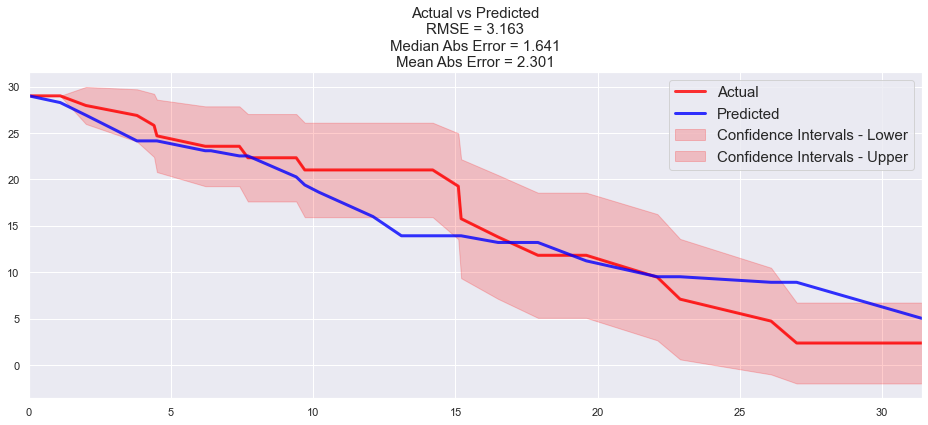

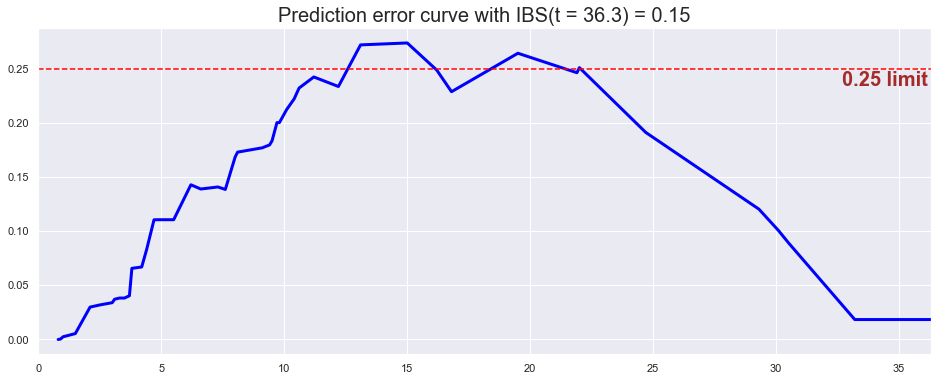

C-index: 0.55
IBS: 0.15

 2 of kfold 3


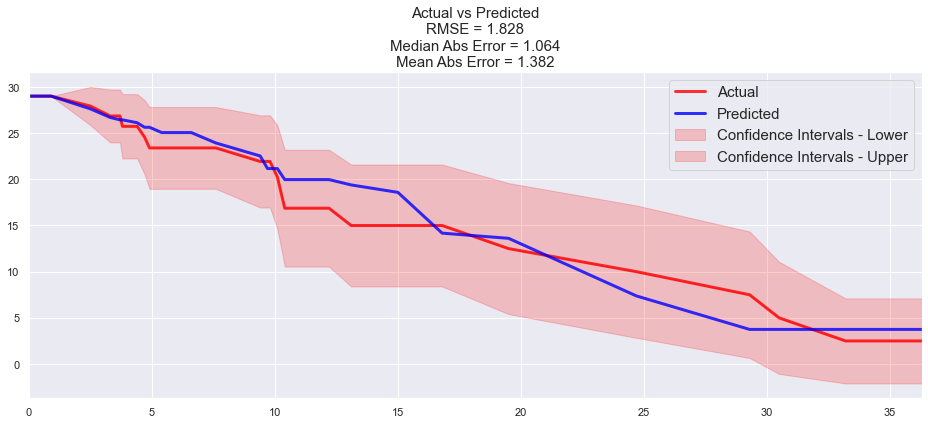

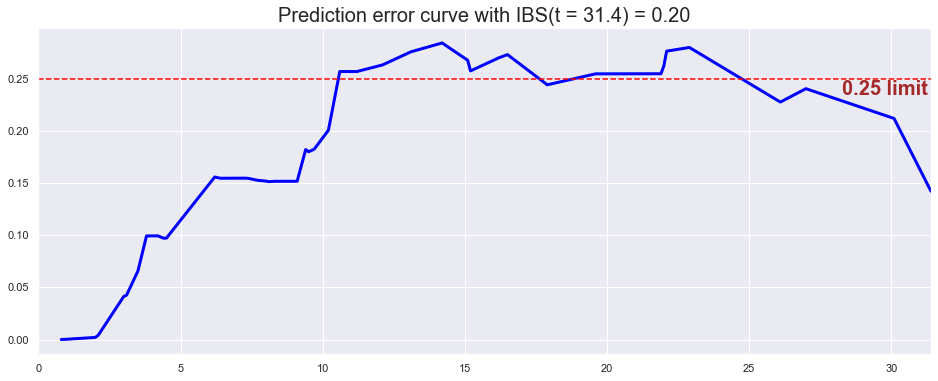

C-index: 0.54
IBS: 0.20

 3 of kfold 3


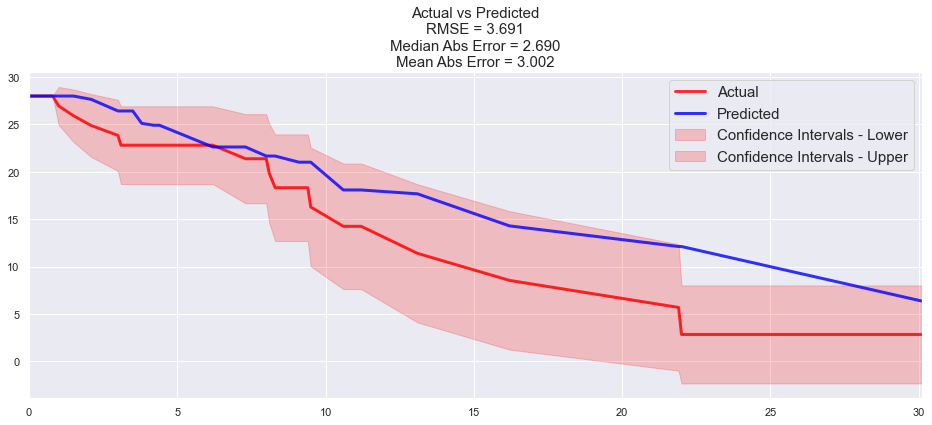

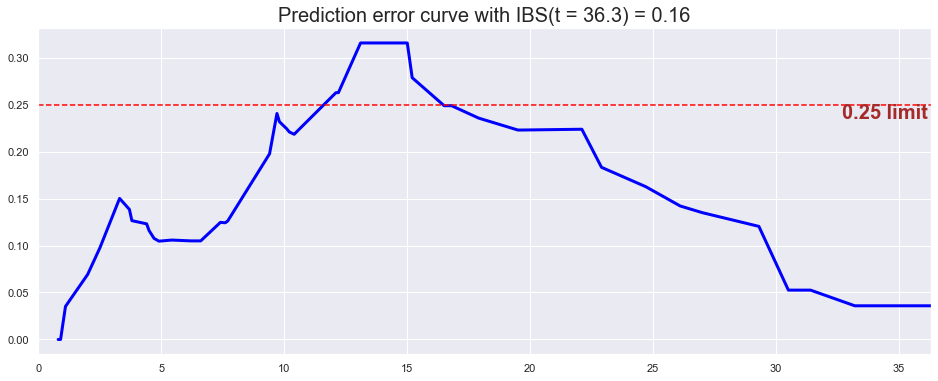

C-index: 0.60
IBS: 0.16

 

Processing: liver_sub_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


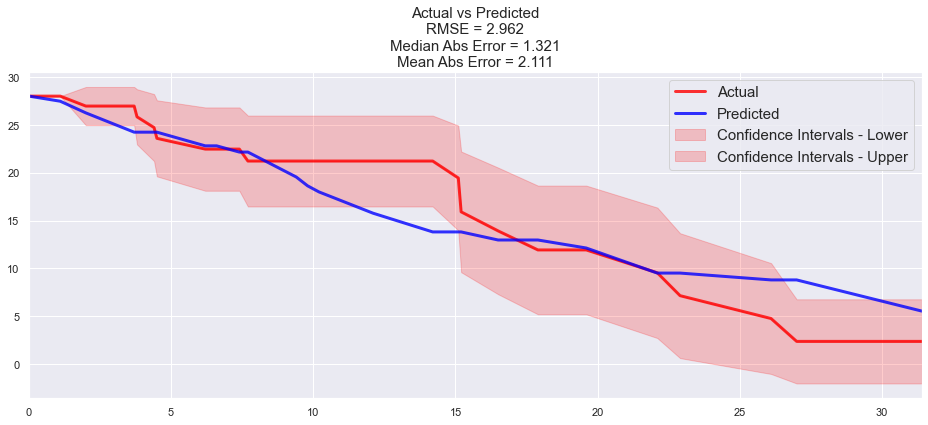

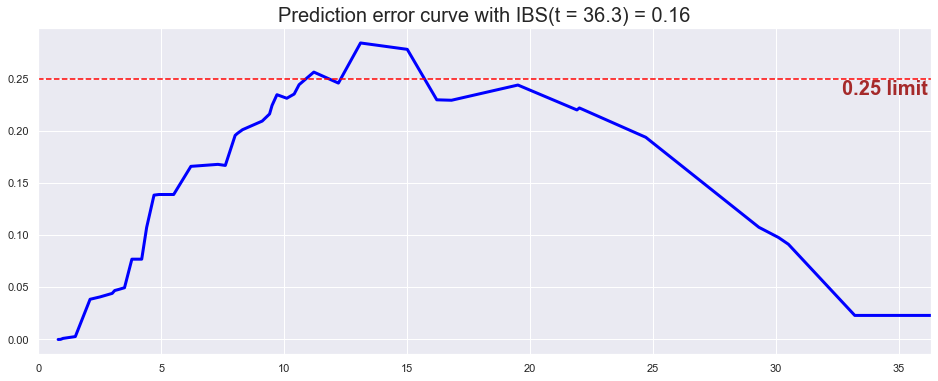

C-index: 0.54
IBS: 0.16

 2 of kfold 3


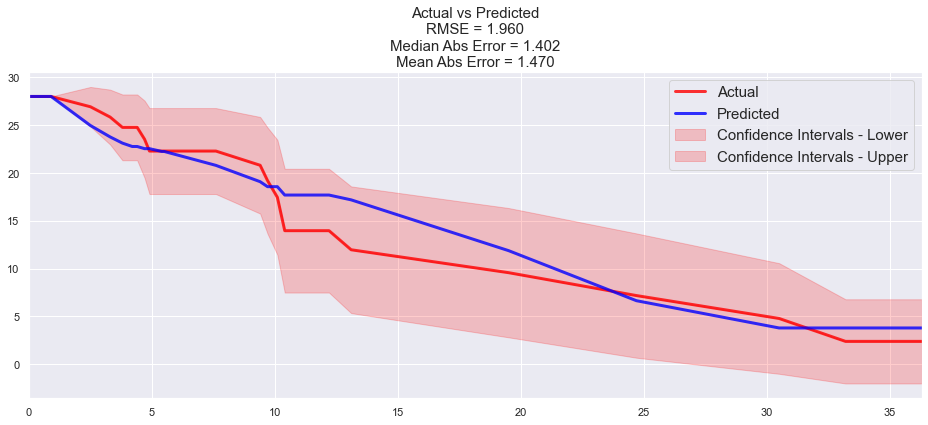

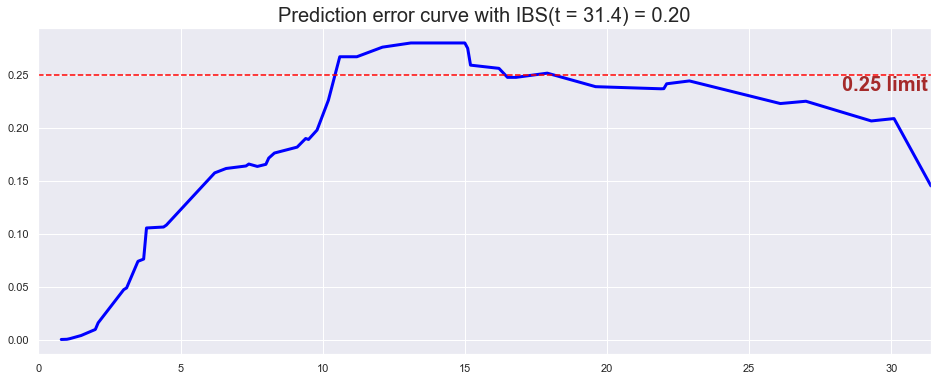

C-index: 0.54
IBS: 0.20

 3 of kfold 3


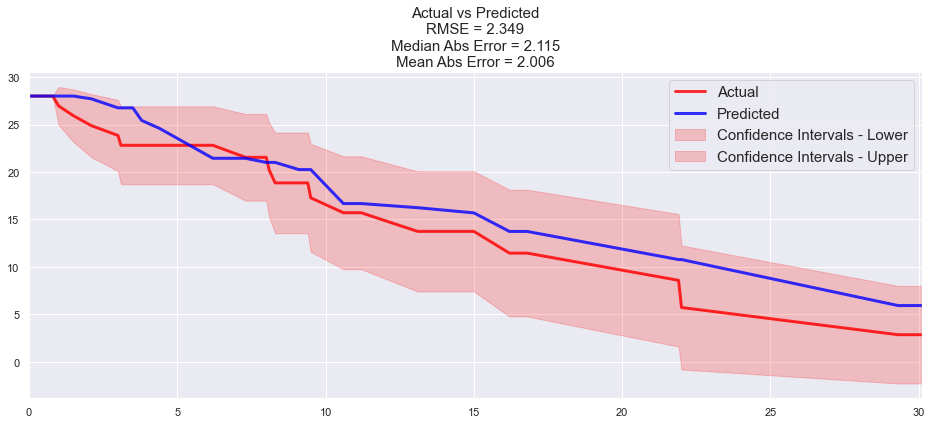

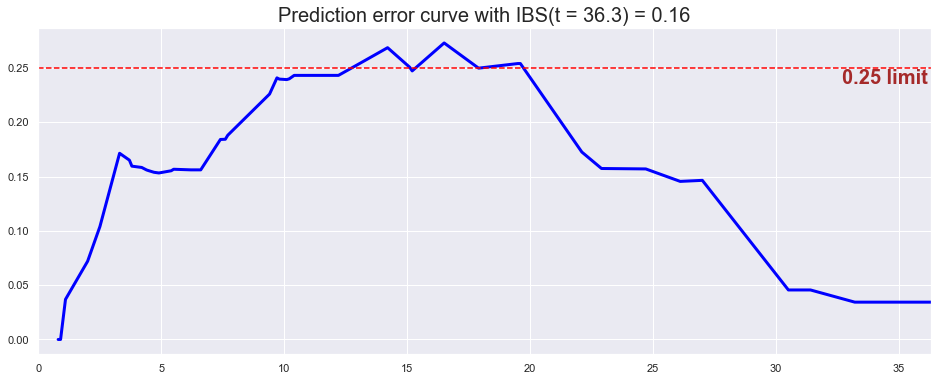

C-index: 0.55
IBS: 0.16

 

Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


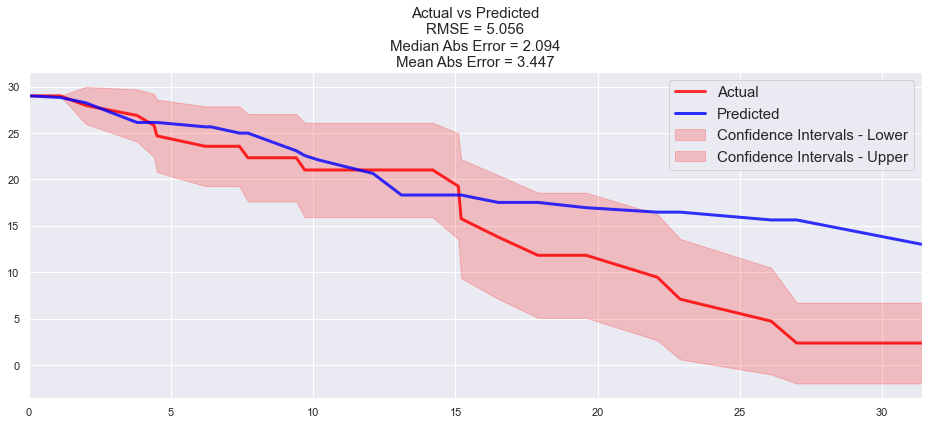

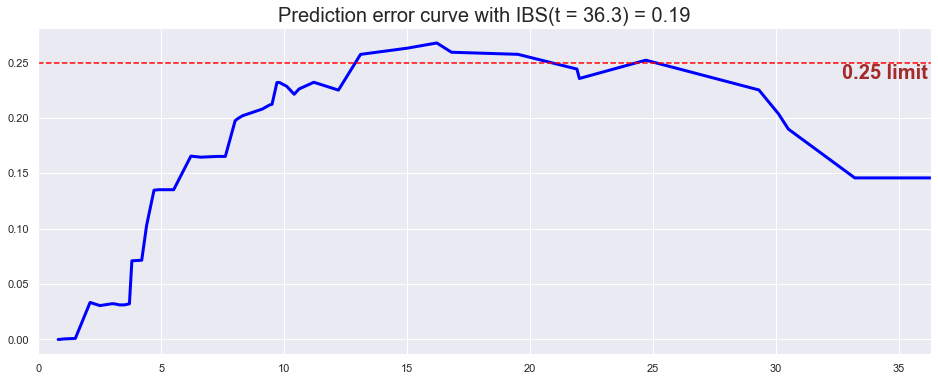

C-index: 0.53
IBS: 0.19

 2 of kfold 3


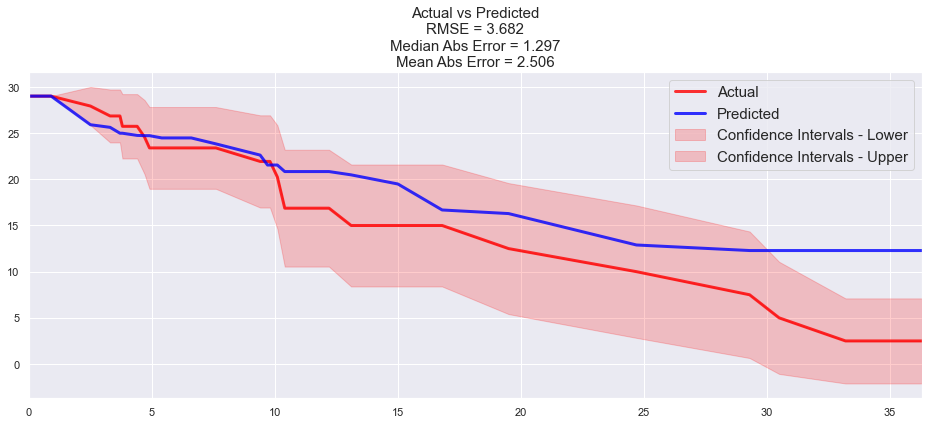

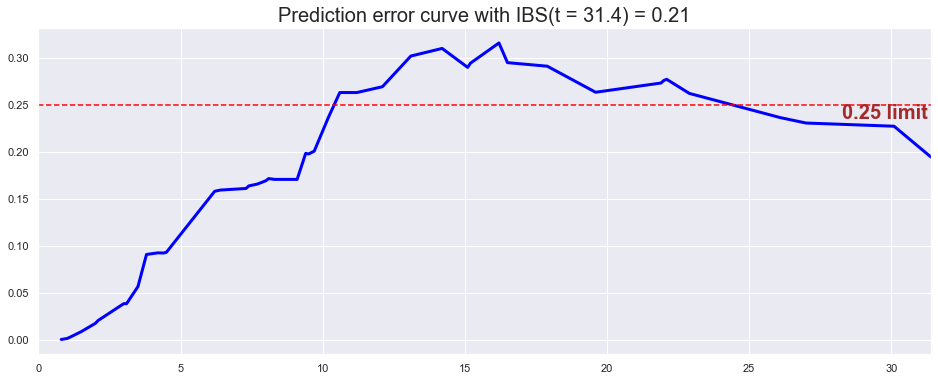

C-index: 0.50
IBS: 0.21

 3 of kfold 3


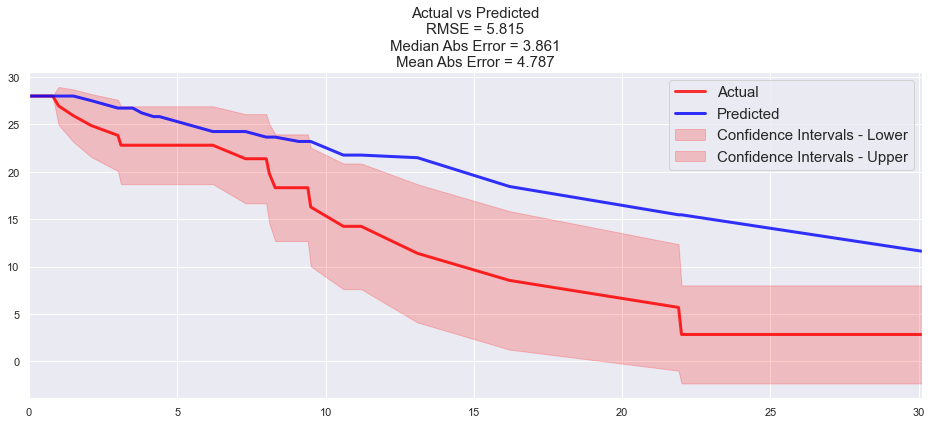

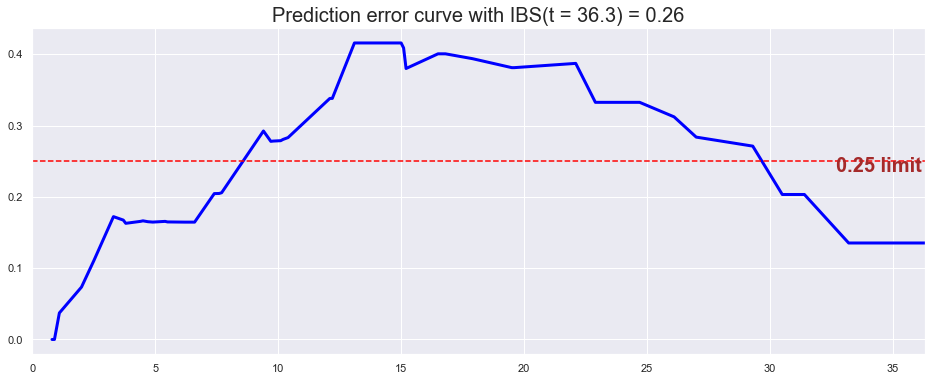

C-index: 0.55
IBS: 0.26

 

Processing: gtv_0.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_0.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


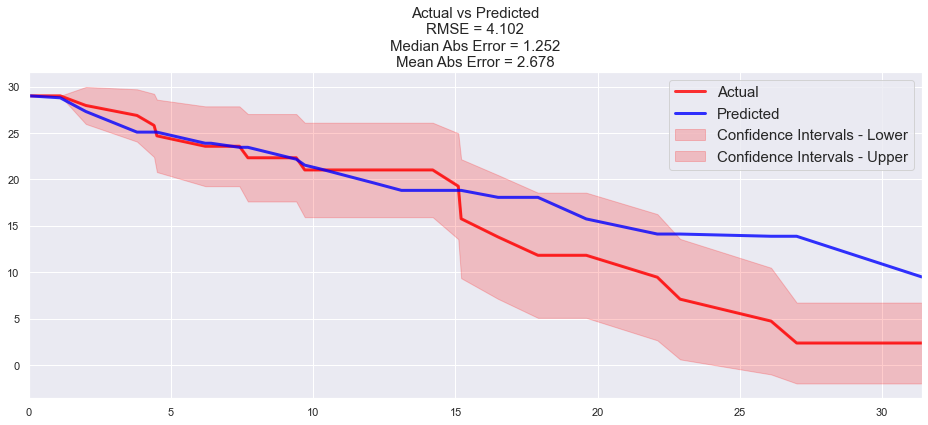

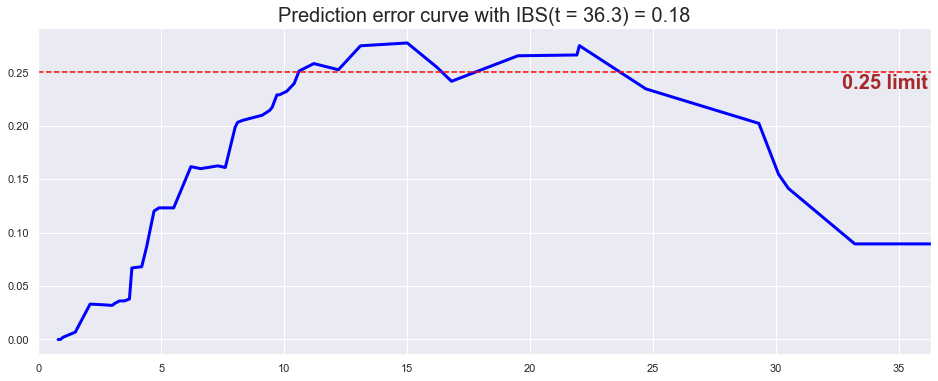

C-index: 0.62
IBS: 0.18

 2 of kfold 3


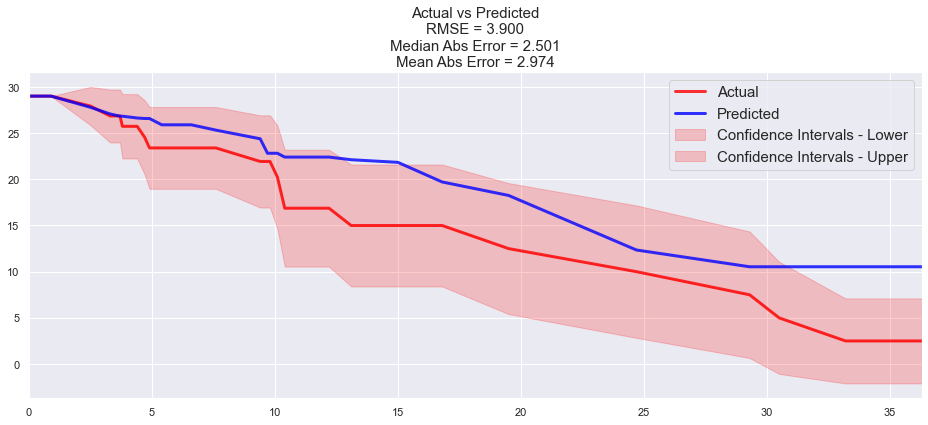

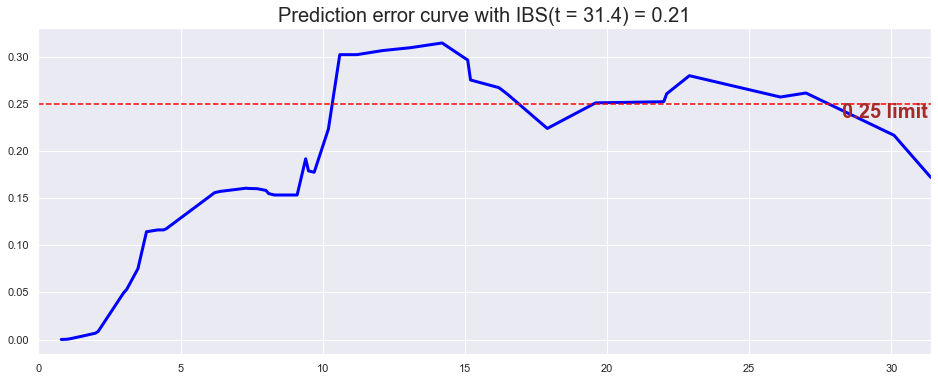

C-index: 0.63
IBS: 0.21

 3 of kfold 3


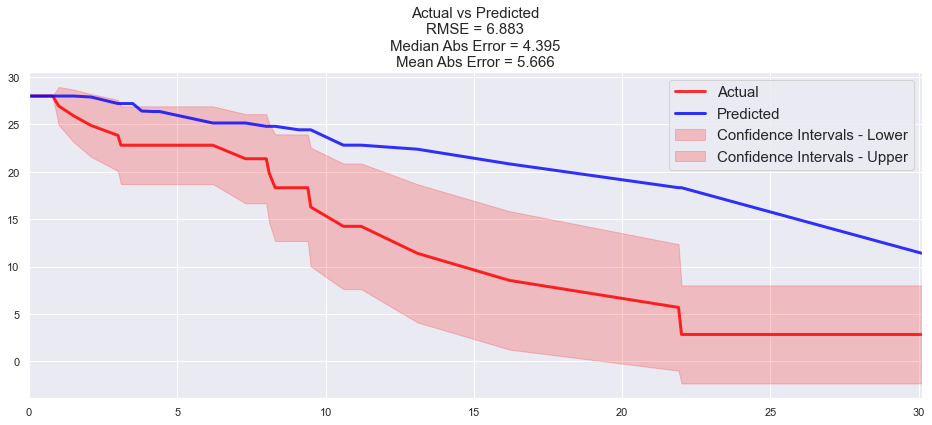

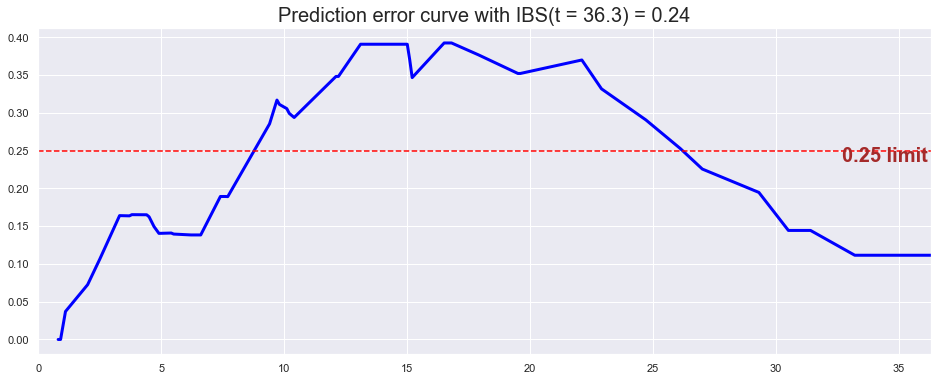

C-index: 0.60
IBS: 0.24

 

Processing: gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


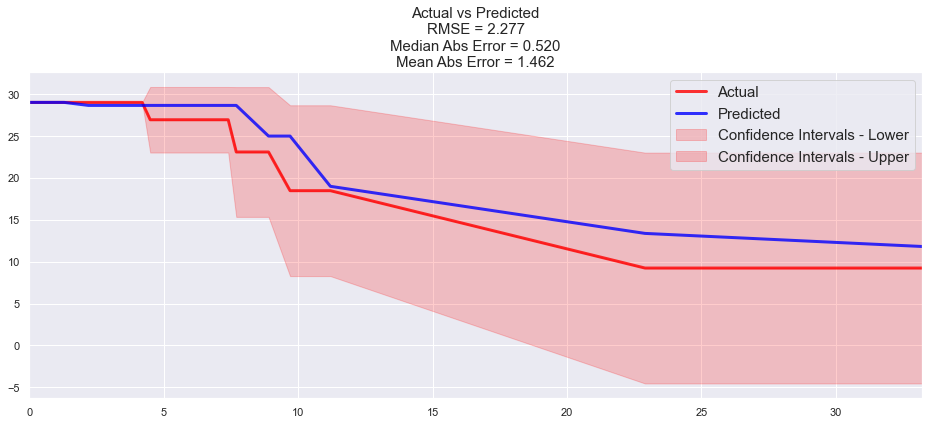

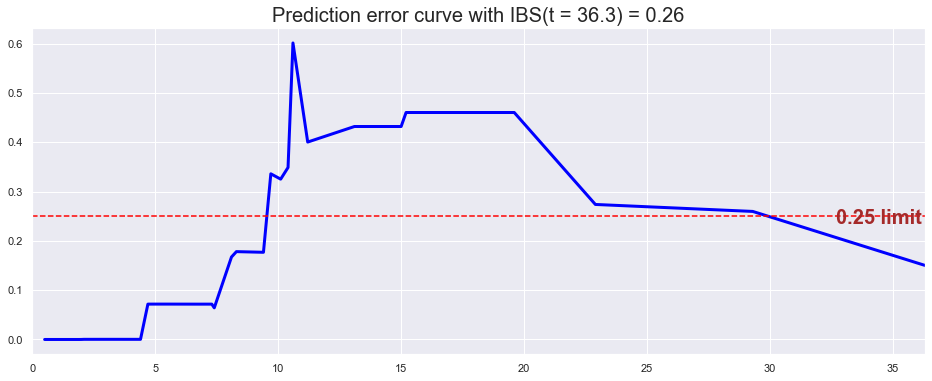

C-index: 0.51
IBS: 0.26

 2 of kfold 3


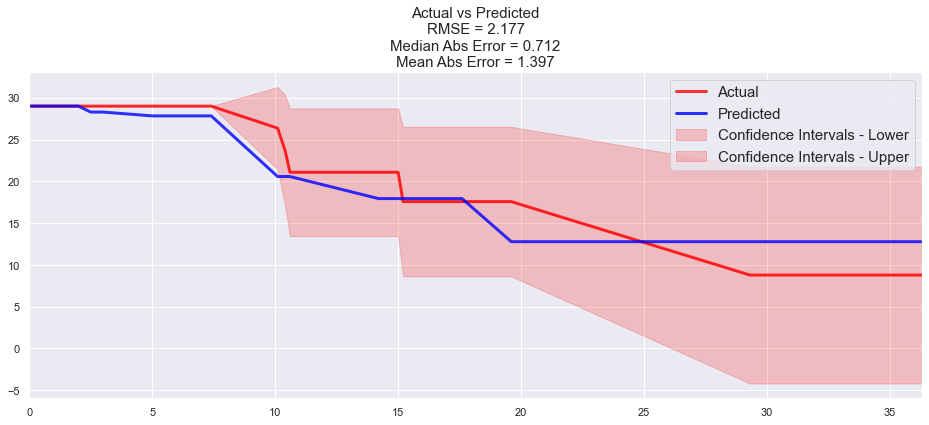

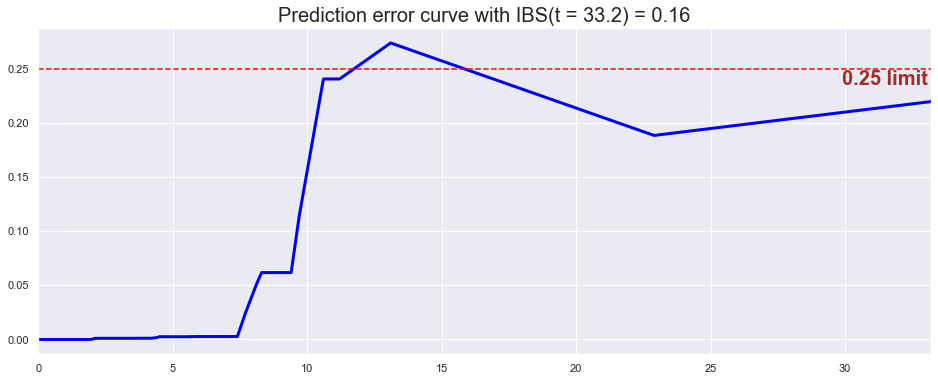

C-index: 0.67
IBS: 0.16

 3 of kfold 3


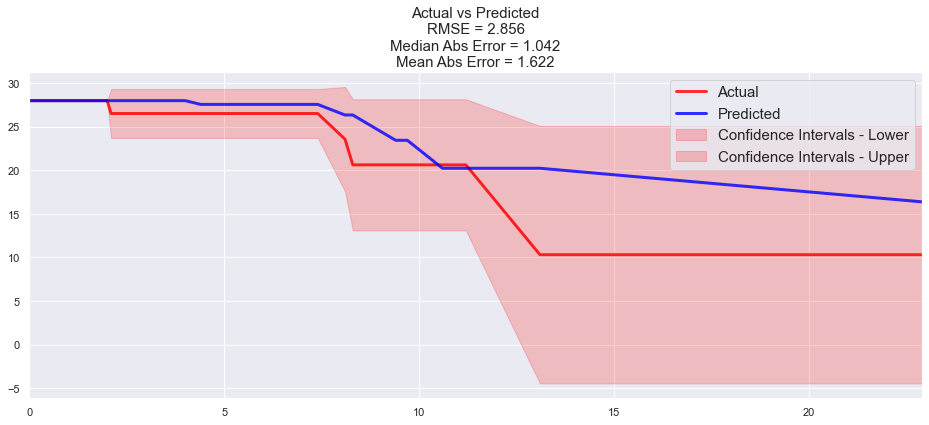

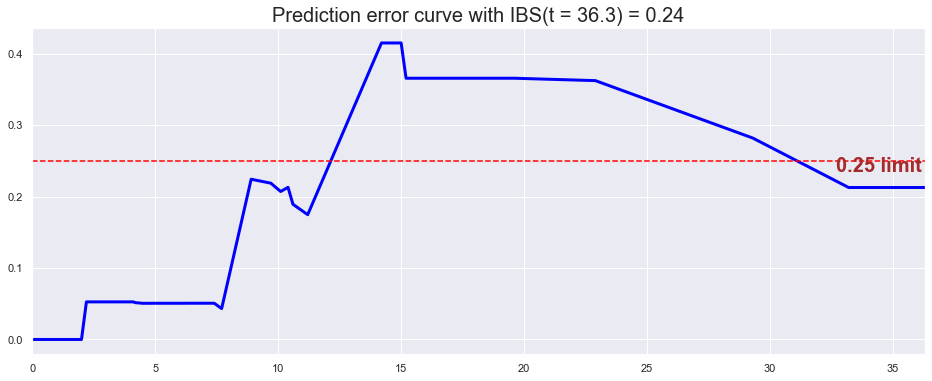

C-index: 0.57
IBS: 0.24

 

Processing: liver_sub_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


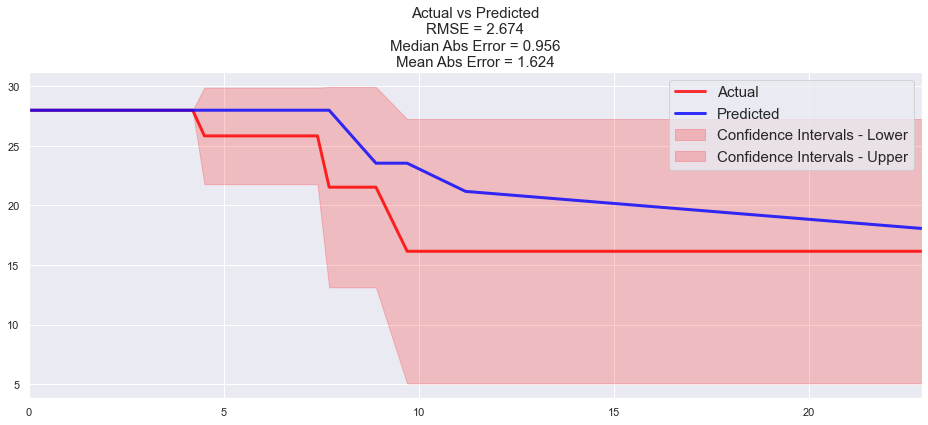

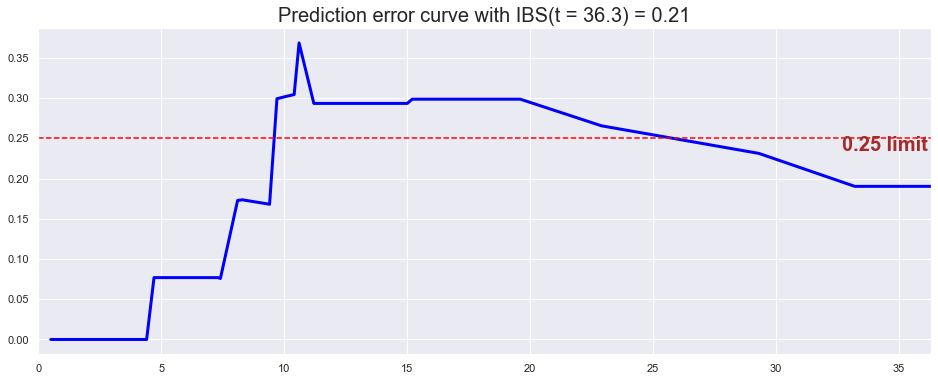

C-index: 0.64
IBS: 0.21

 2 of kfold 3


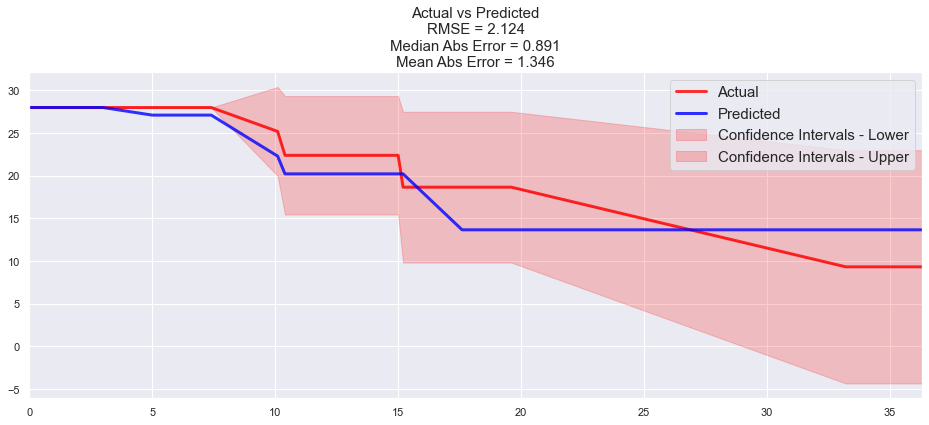

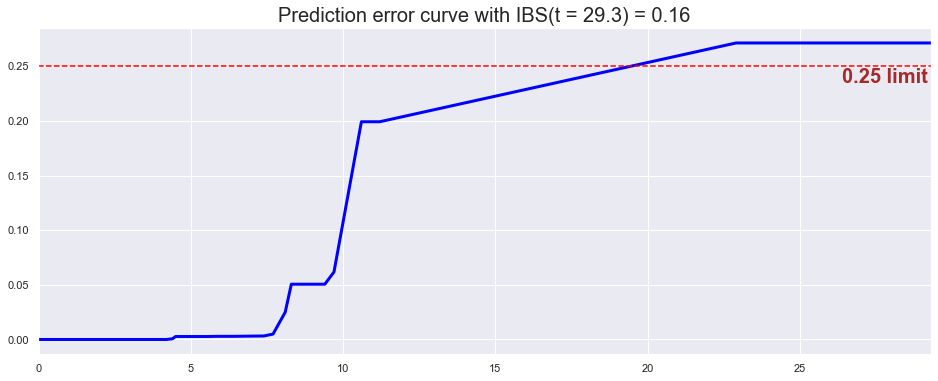

C-index: 0.77
IBS: 0.16

 3 of kfold 3


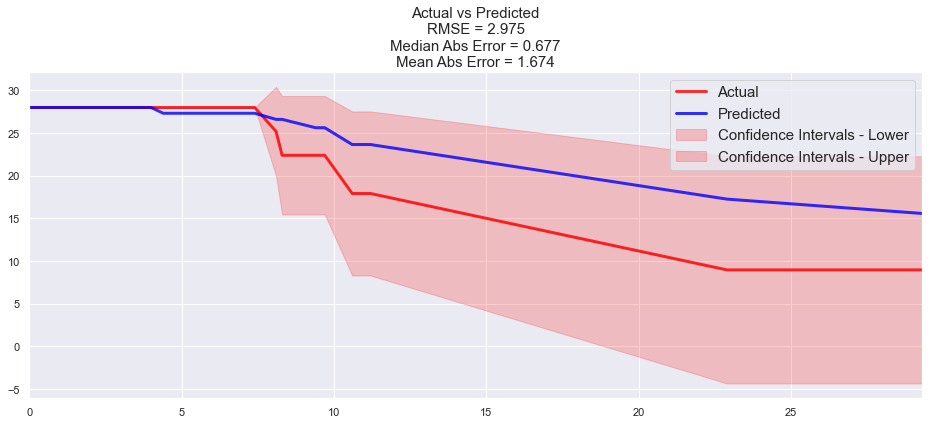

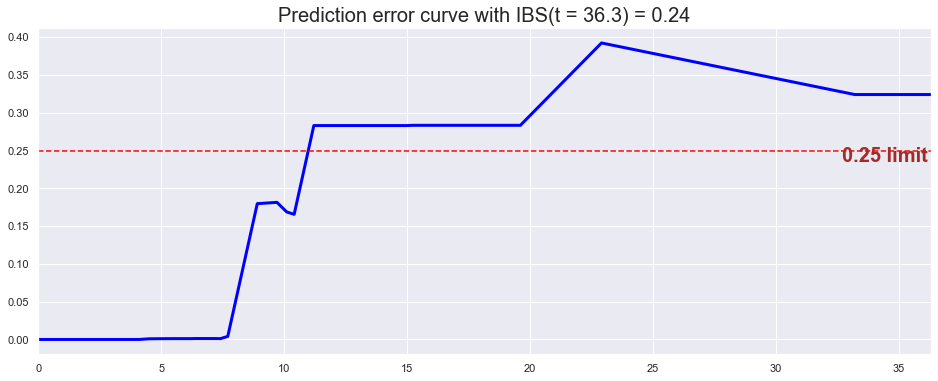

C-index: 0.56
IBS: 0.24

 

Processing: liver_plus_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


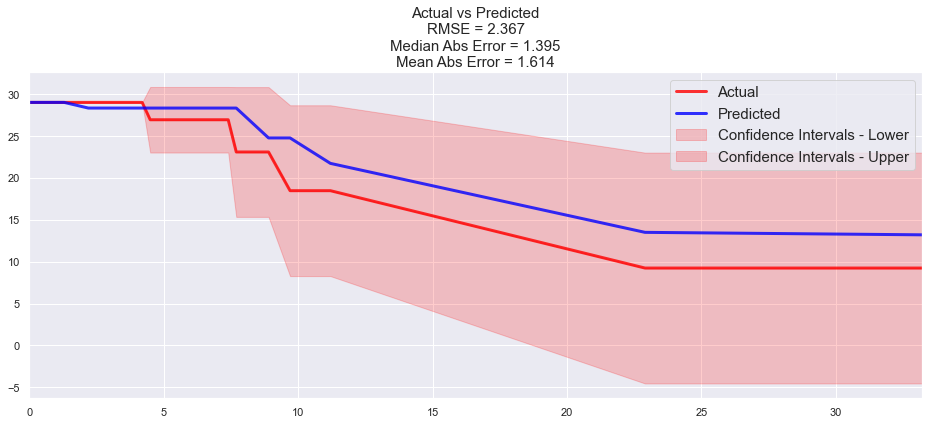

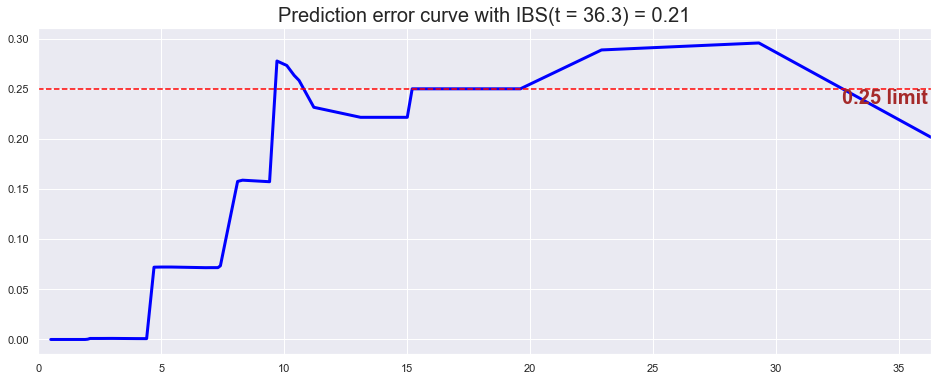

C-index: 0.74
IBS: 0.21

 2 of kfold 3


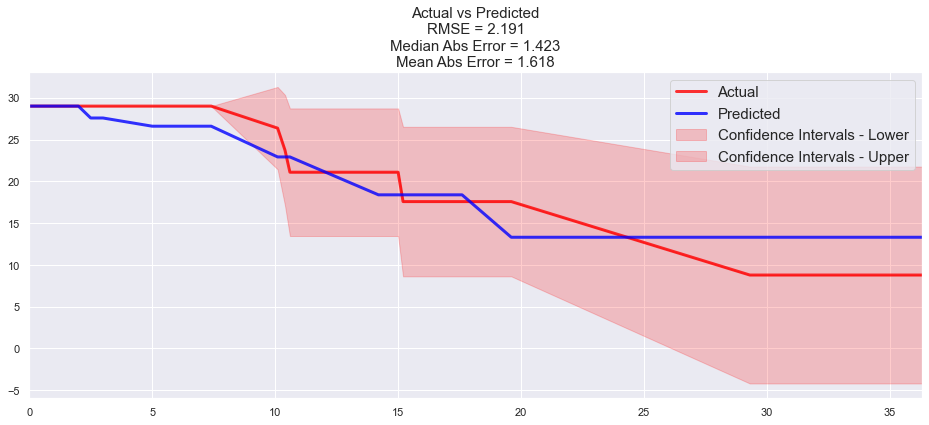

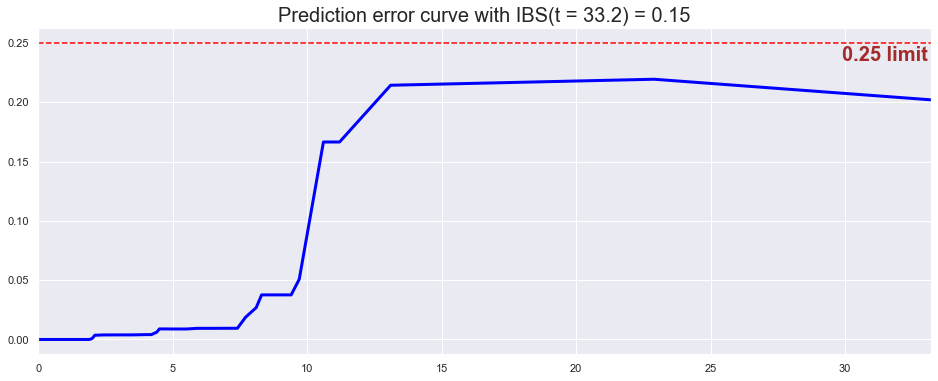

C-index: 0.83
IBS: 0.15

 3 of kfold 3


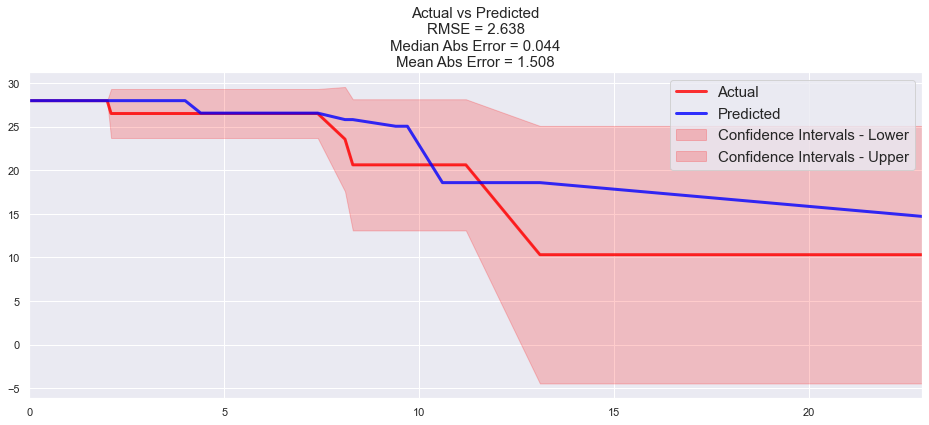

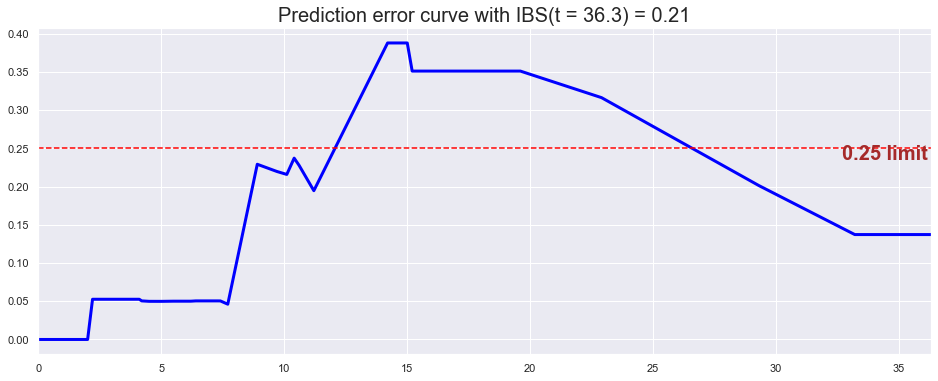

C-index: 0.70
IBS: 0.21

 

Processing: gtv_0_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_0_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


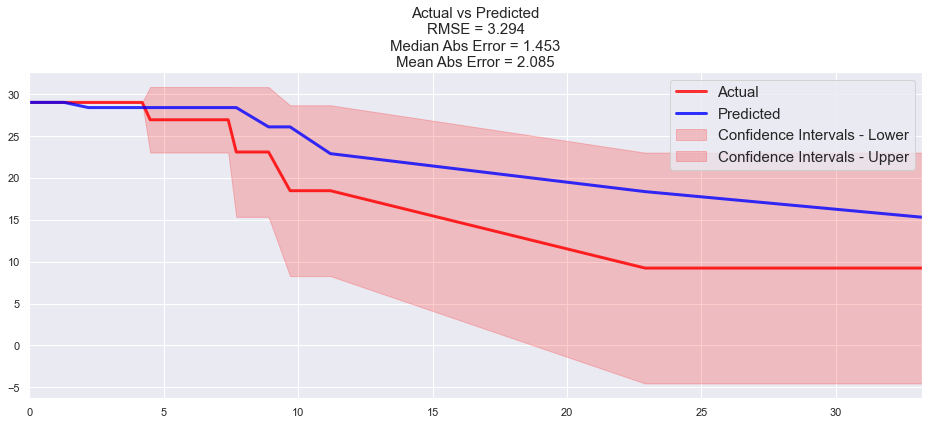

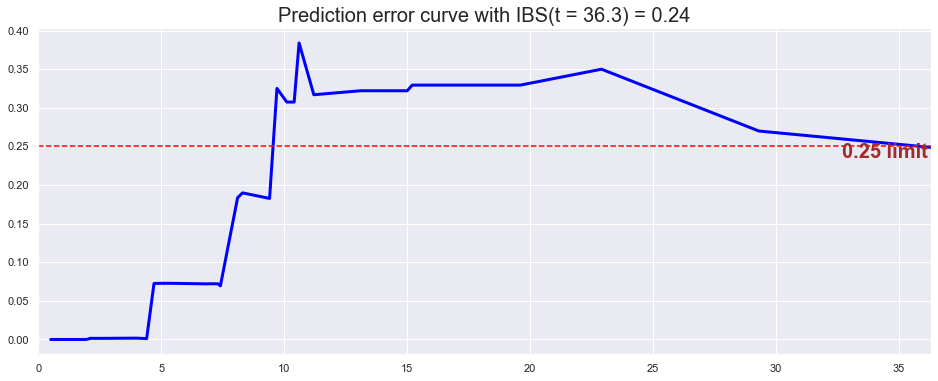

C-index: 0.52
IBS: 0.24

 2 of kfold 3


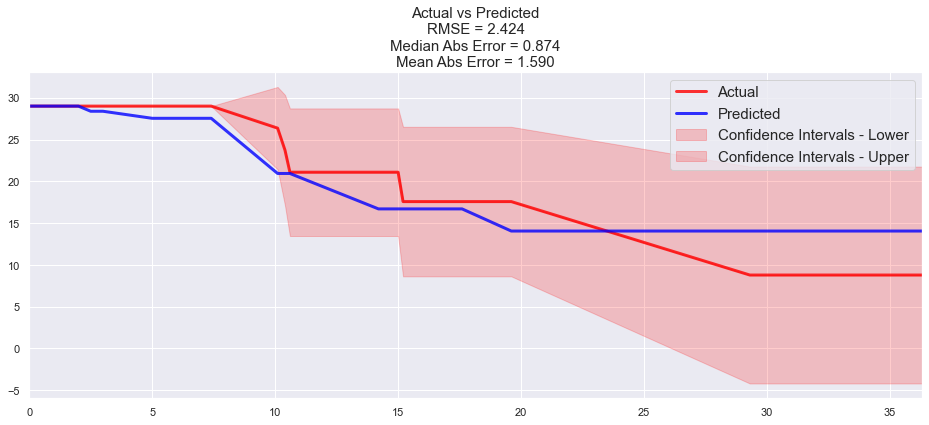

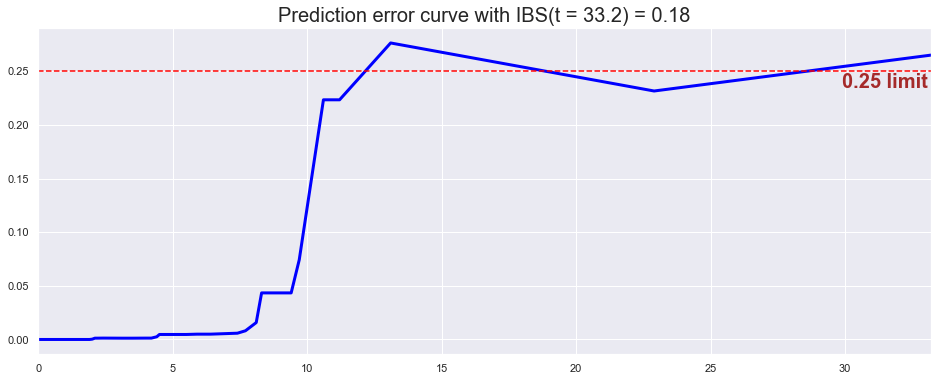

C-index: 0.53
IBS: 0.18

 3 of kfold 3


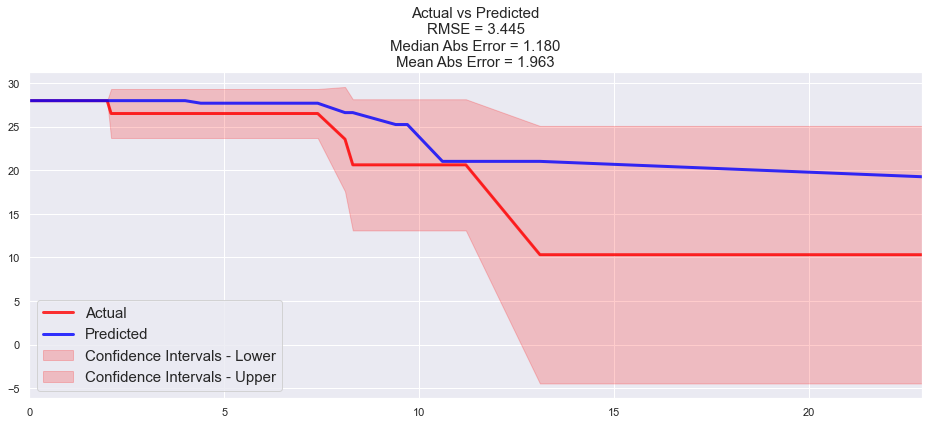

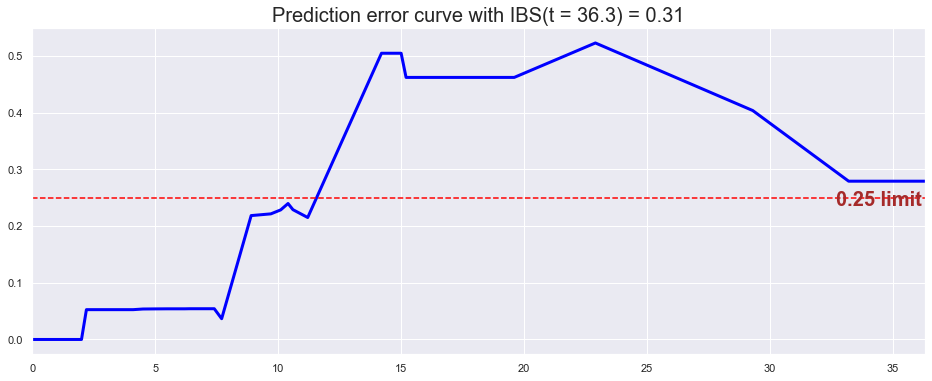

C-index: 0.76
IBS: 0.31

 

Processing: clin_variables_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


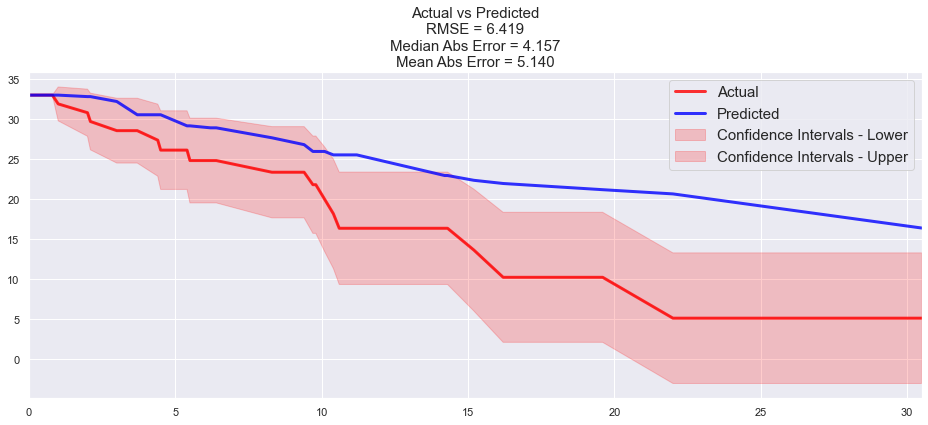

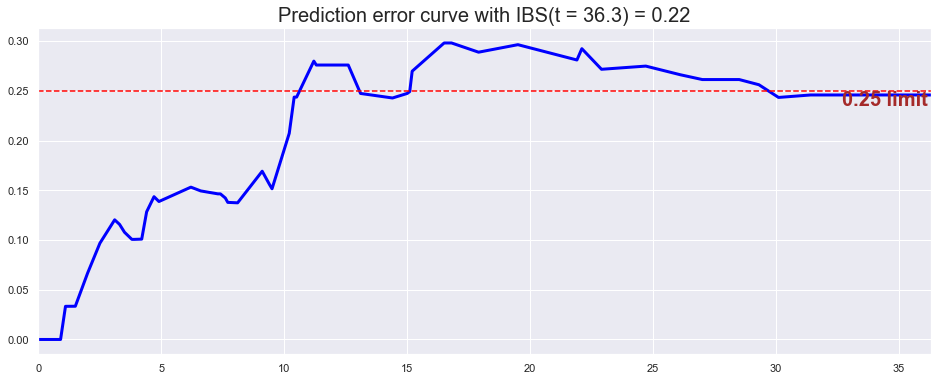

C-index: 0.77
IBS: 0.22

 2 of kfold 3


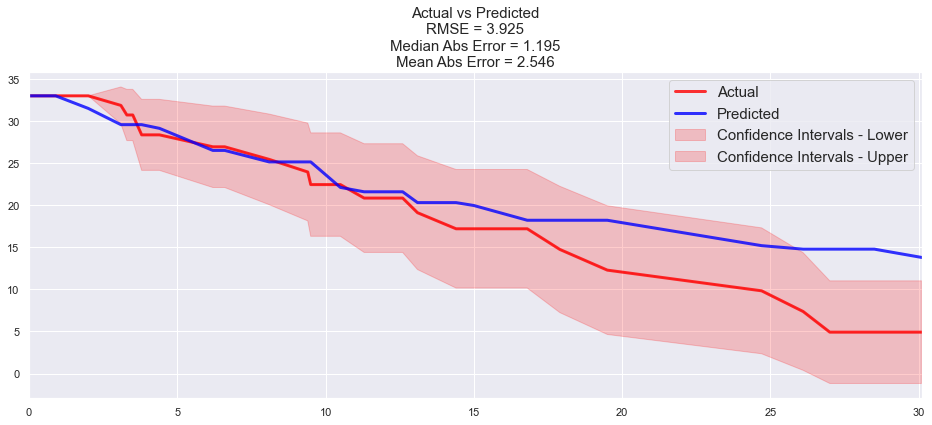

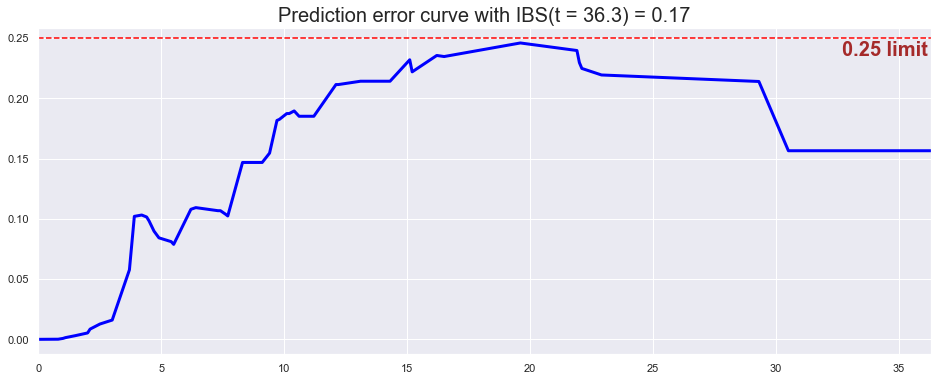

C-index: 0.65
IBS: 0.17

 3 of kfold 3


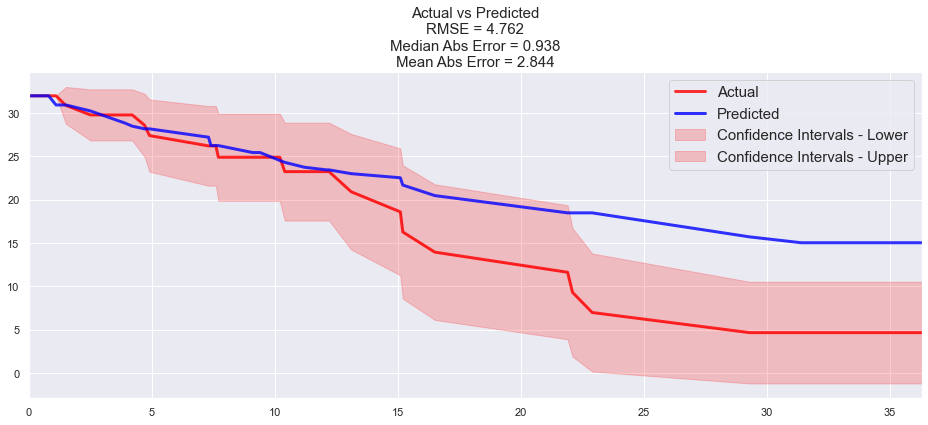

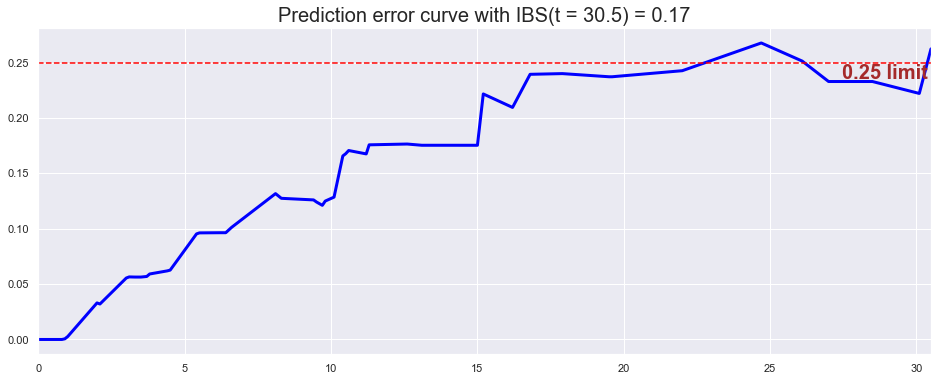

C-index: 0.81
IBS: 0.17

 

Processing: clin_variables_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


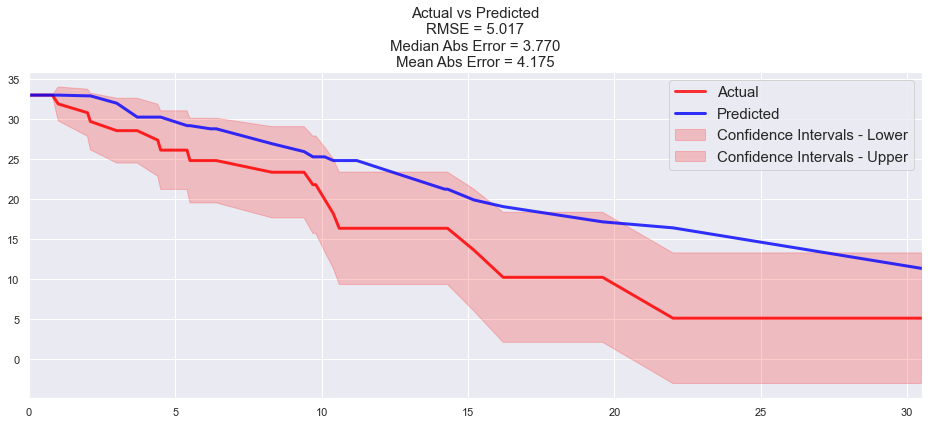

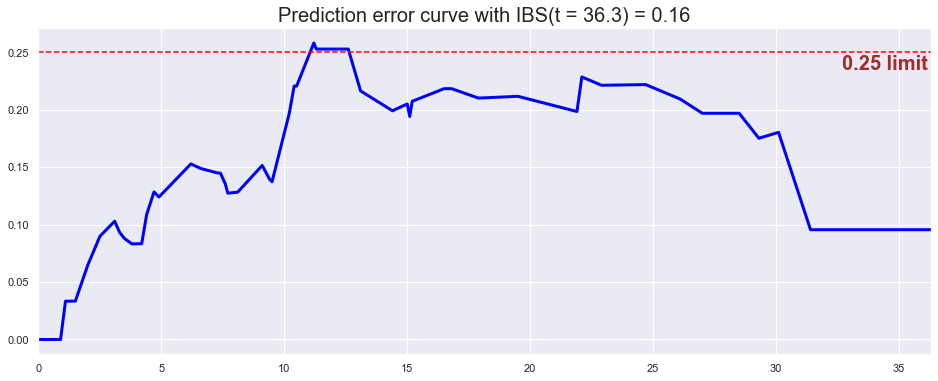

C-index: 0.79
IBS: 0.16

 2 of kfold 3


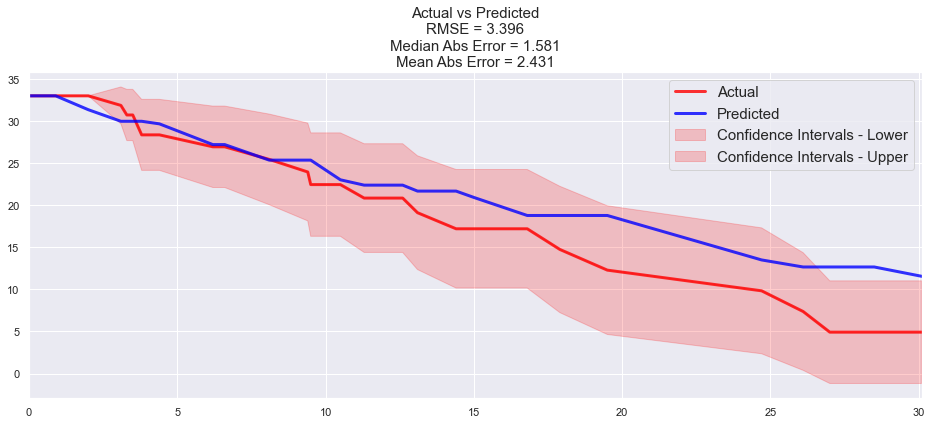

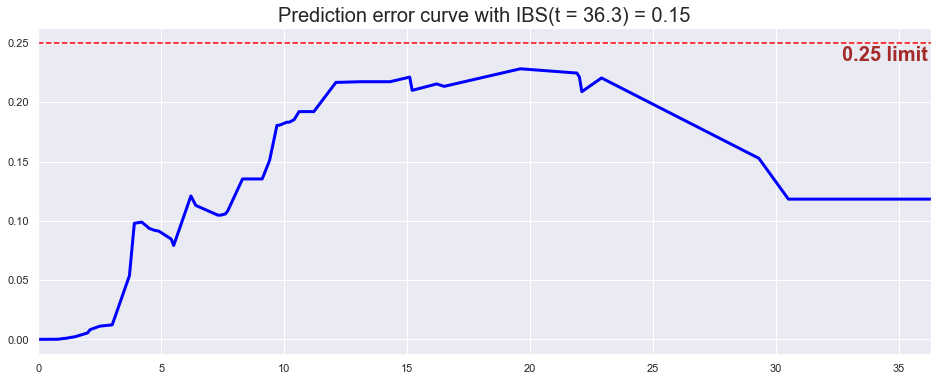

C-index: 0.76
IBS: 0.15

 3 of kfold 3


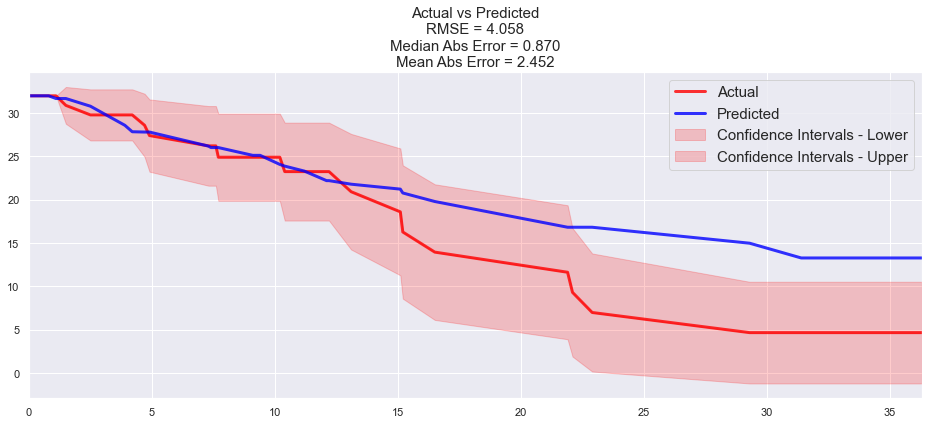

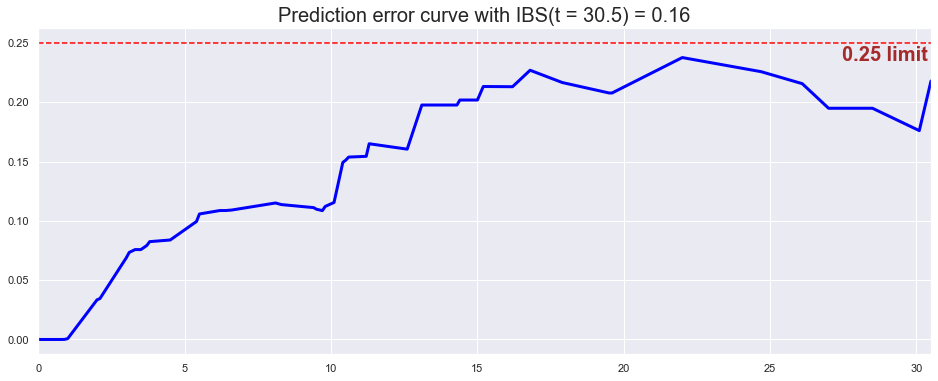

C-index: 0.66
IBS: 0.16

 

Processing: clin_variables_non_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_non_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


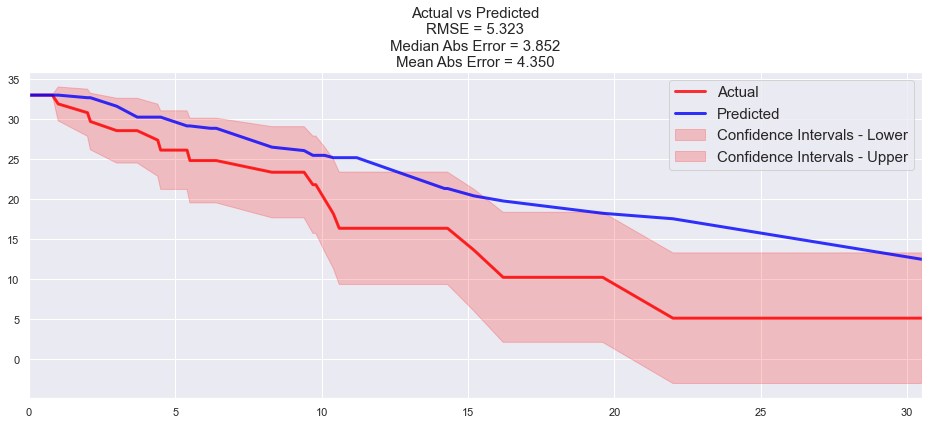

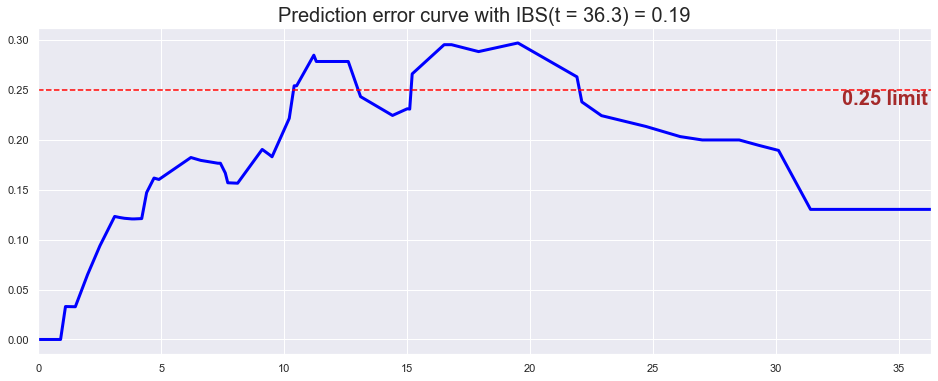

C-index: 0.69
IBS: 0.19

 2 of kfold 3


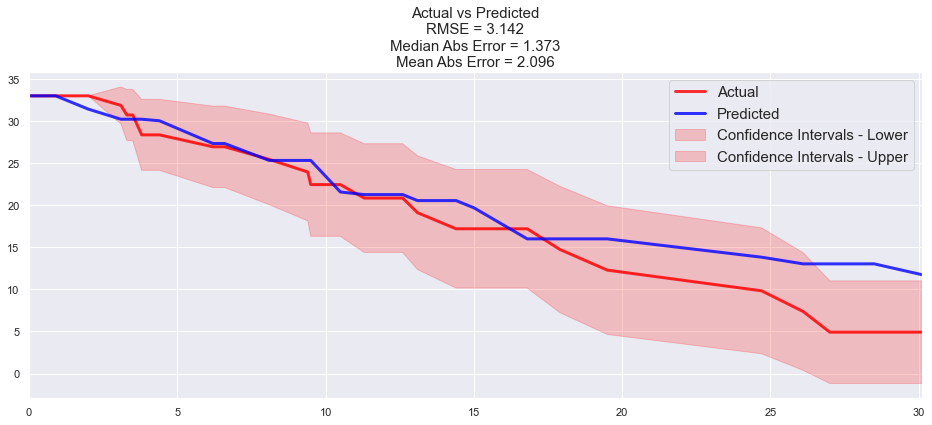

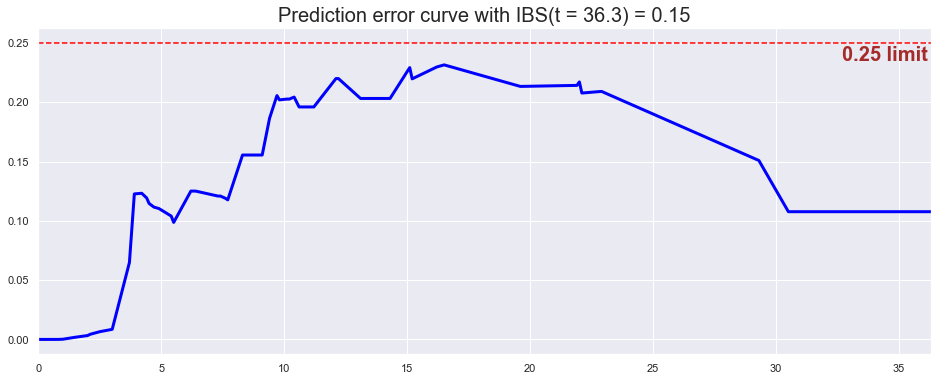

C-index: 0.70
IBS: 0.15

 3 of kfold 3


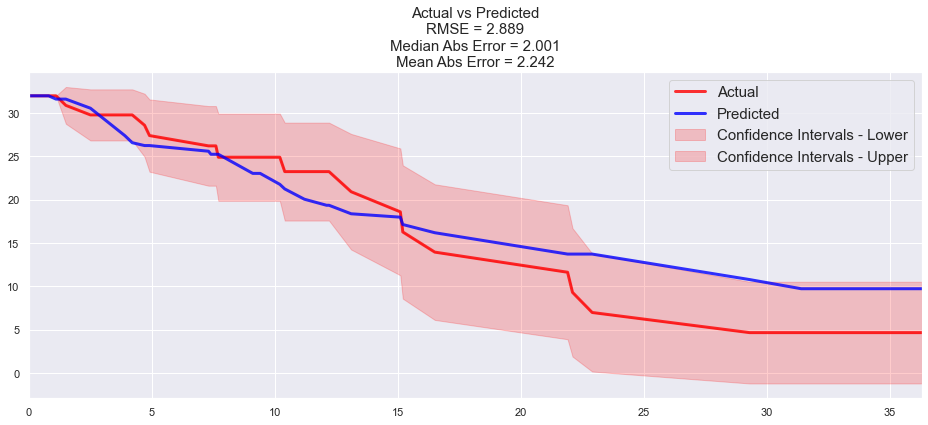

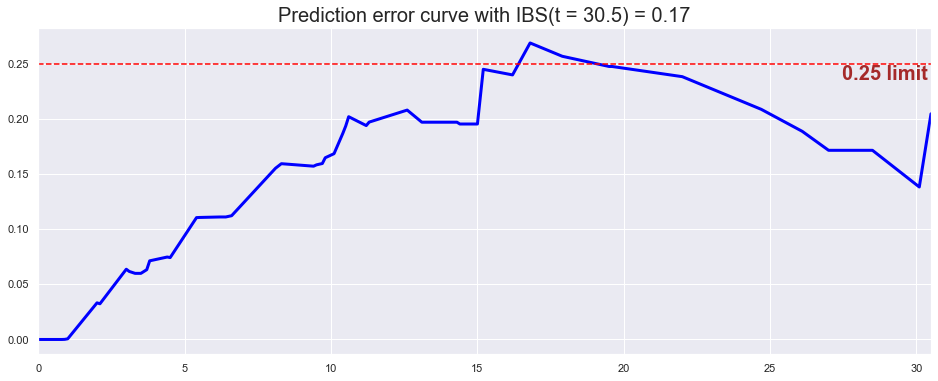

C-index: 0.63
IBS: 0.17

 

Processing: clin_variables_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


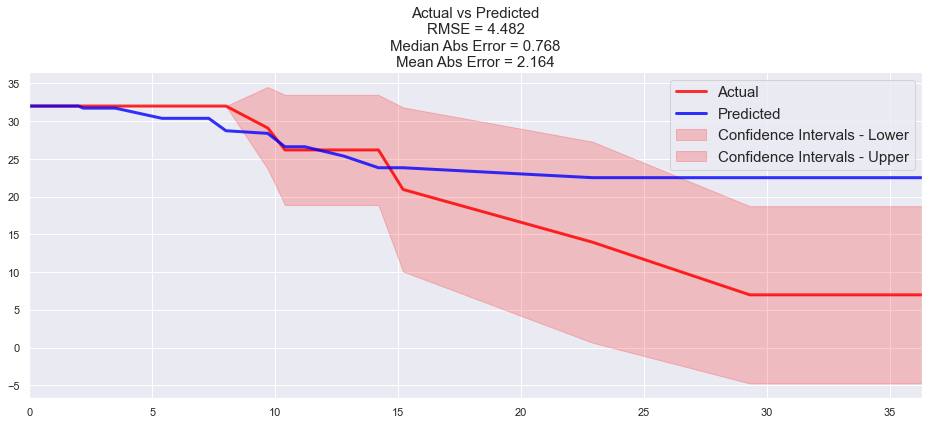

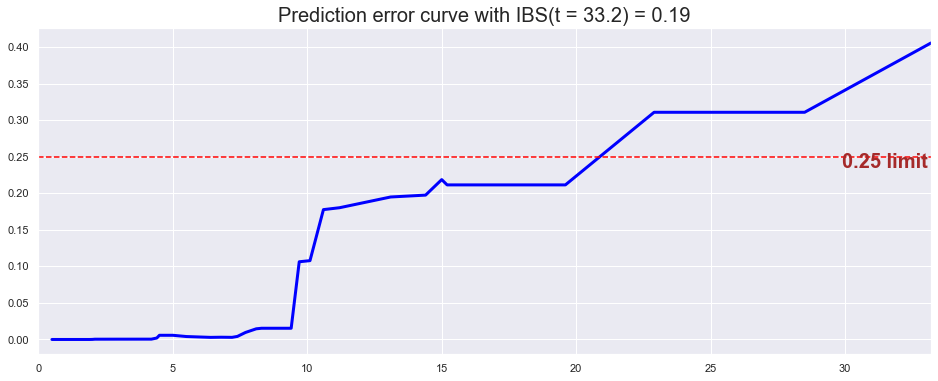

C-index: 0.56
IBS: 0.19

 2 of kfold 3


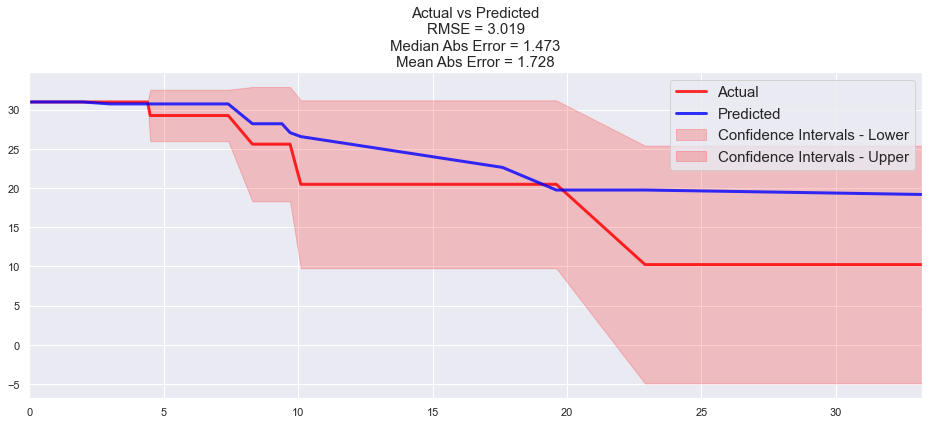

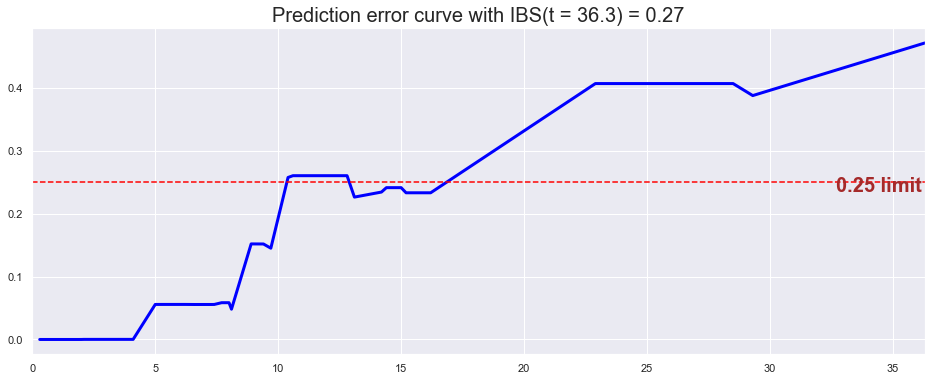

C-index: 0.58
IBS: 0.27

 3 of kfold 3


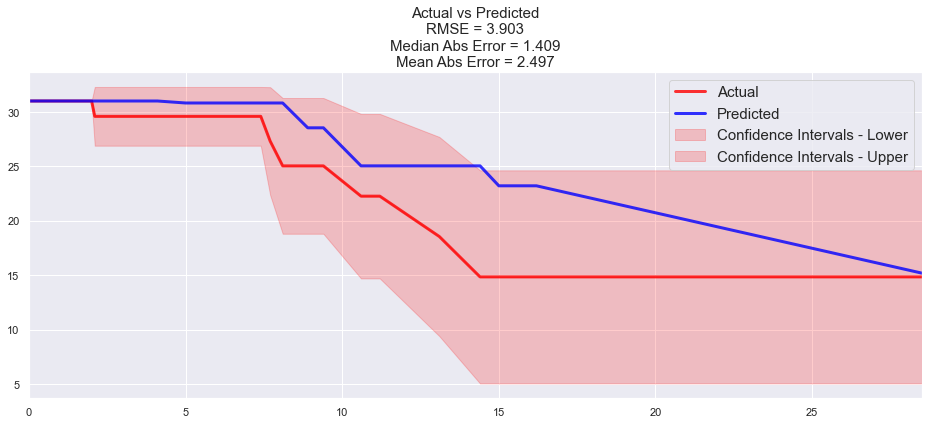

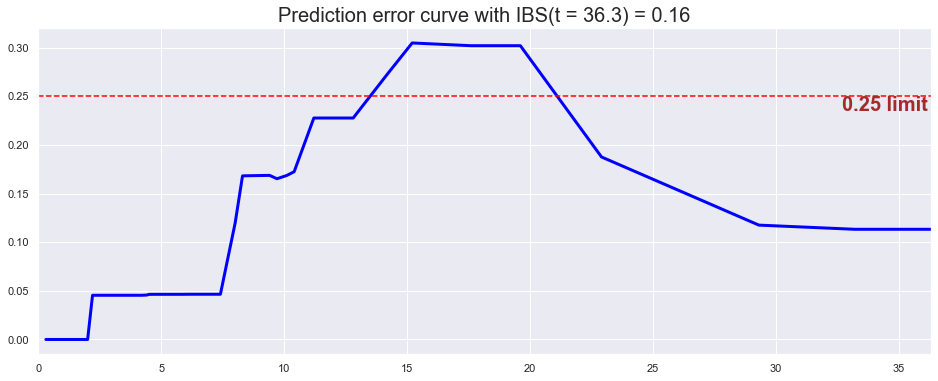

C-index: 0.60
IBS: 0.16

 

Processing: clin_variables_imaging_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


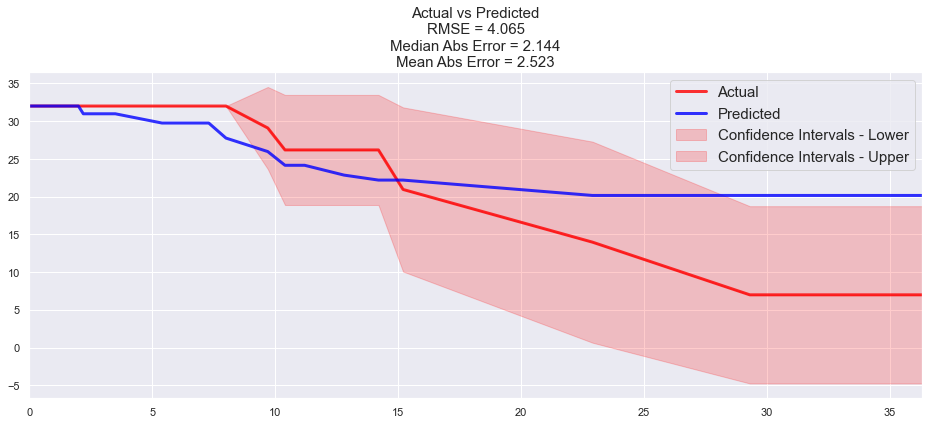

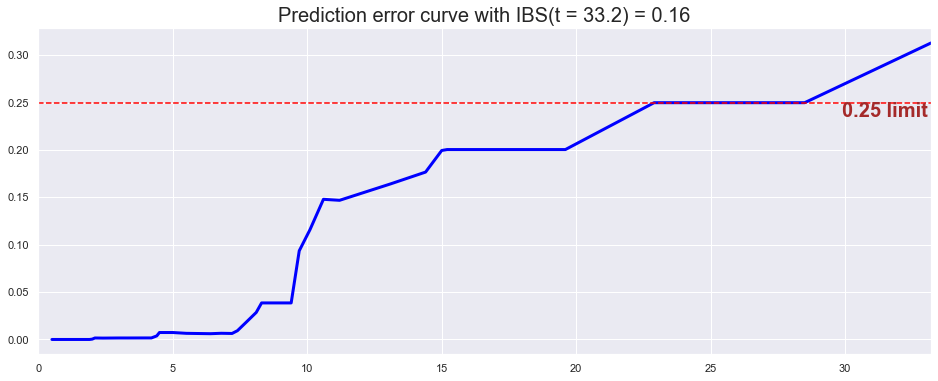

C-index: 0.60
IBS: 0.16

 2 of kfold 3


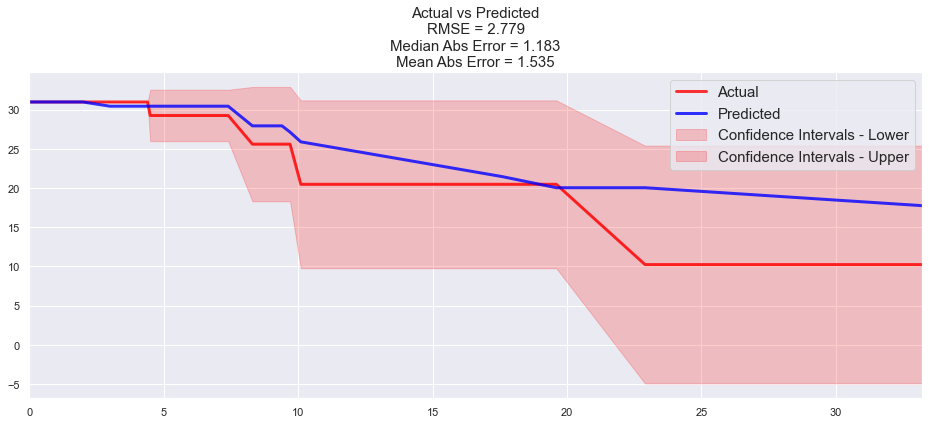

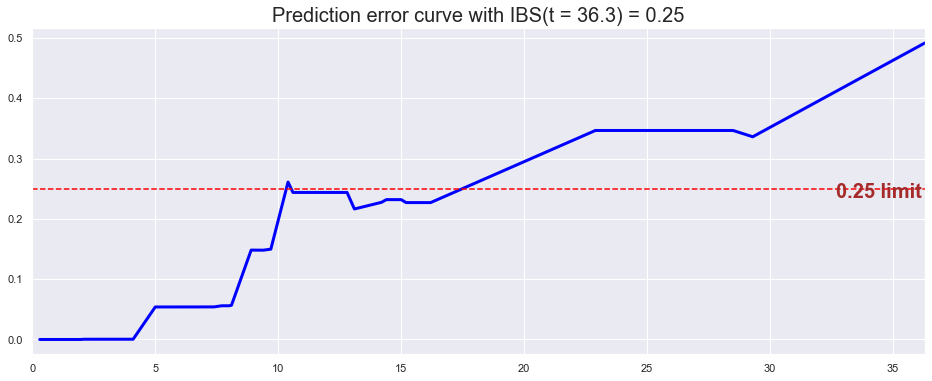

C-index: 0.59
IBS: 0.25

 3 of kfold 3


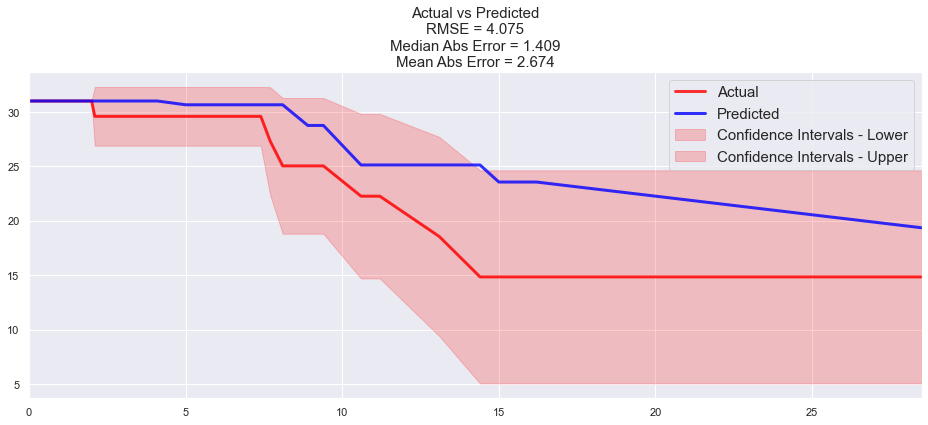

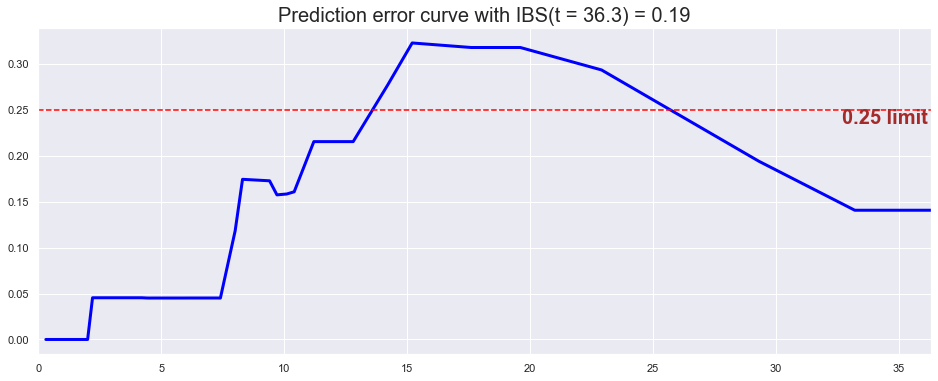

C-index: 0.64
IBS: 0.19

 

Processing: clin_variables_non_imaging_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_non_imaging_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 3


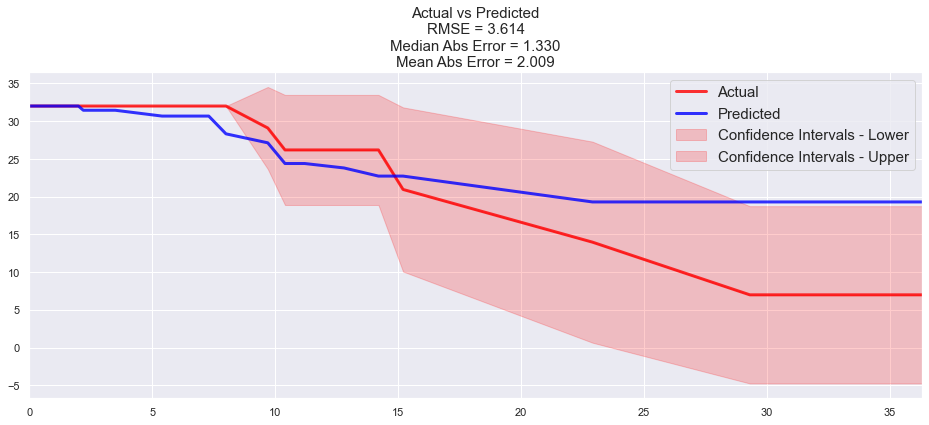

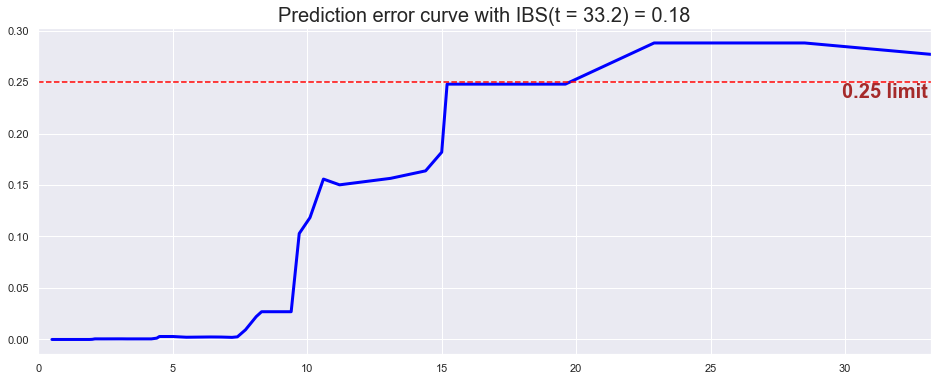

C-index: 0.54
IBS: 0.18

 2 of kfold 3


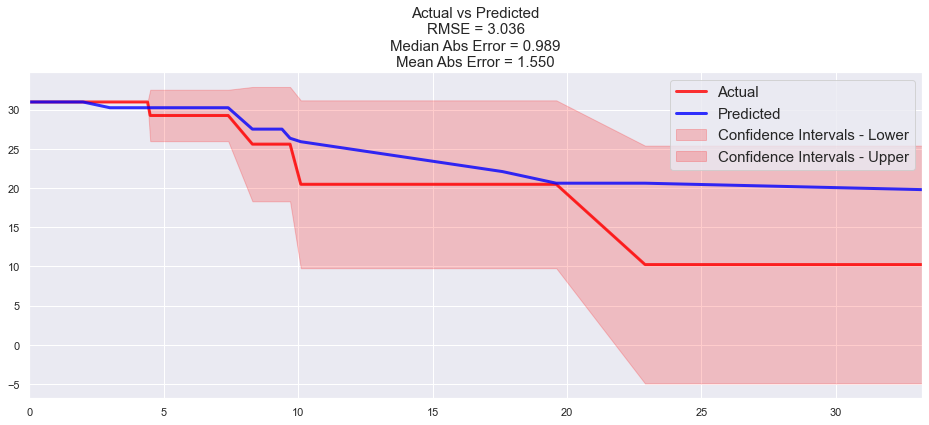

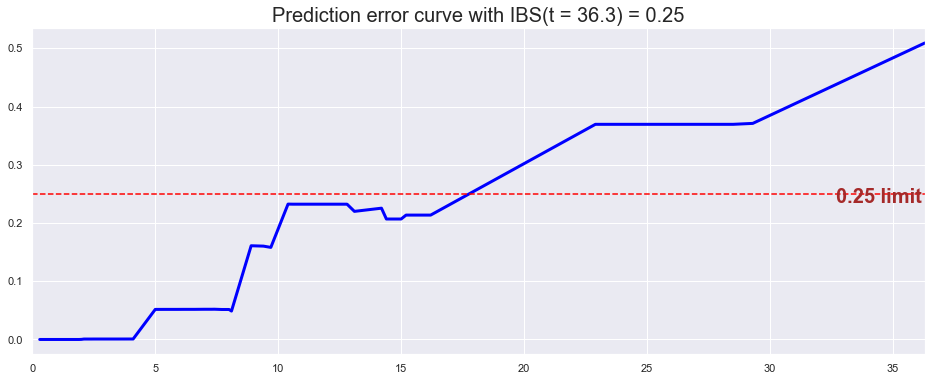

C-index: 0.50
IBS: 0.25

 3 of kfold 3


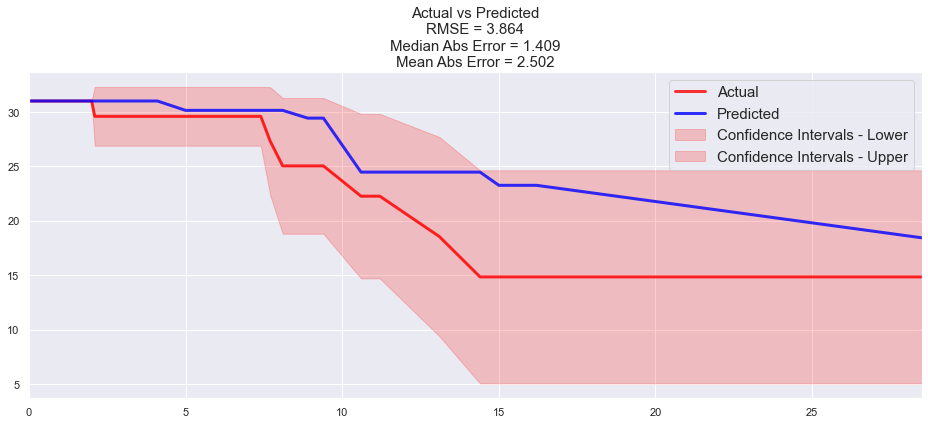

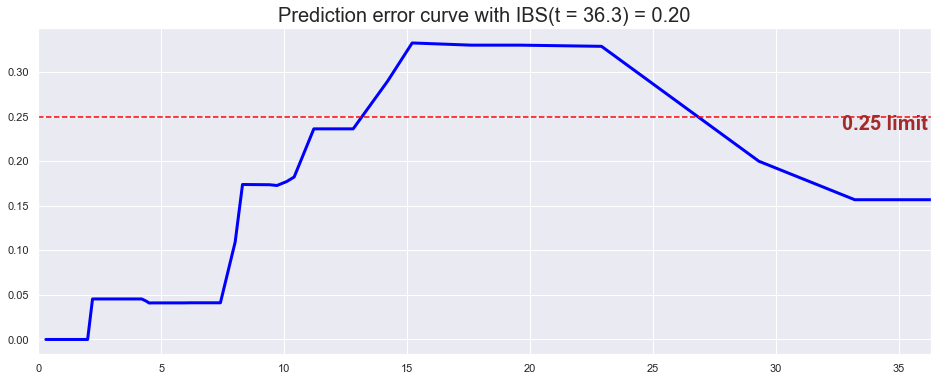

C-index: 0.51
IBS: 0.20

 

                                   Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.759870  0.565755   
1                     liver_sub_gtv.csv            0.725754  0.543275   
2                    liver_plus_gtv.csv            0.714376  0.526151   
3                             gtv_0.csv            0.753913  0.615947   
4                            gtv_hp.csv            0.873810  0.583373   
5                  liver_sub_gtv_hp.csv            0.860498  0.658752   
6                 liver_plus_gtv_hp.csv            0.848197  0.757677   
7                          gtv_0_hp.csv            0.846394  0.601004   
8               clin_variables_fflp.csv            0.796323  0.743401   
9       clin_variables_imaging_fflp.csv            0.814685  0.735026   
10  clin_variables_non_imaging_fflp.csv            0.743317  0.672070   
11                clin_variables_hp.csv            0.839642  0.580948   
12        clin_variable

In [56]:
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

In [57]:
results_DF

Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.759870  0.565755   
1                     liver_sub_gtv.csv            0.725754  0.543275   
2                    liver_plus_gtv.csv            0.714376  0.526151   
3                             gtv_0.csv            0.753913  0.615947   
4                            gtv_hp.csv            0.873810  0.583373   
5                  liver_sub_gtv_hp.csv            0.860498  0.658752   
6                 liver_plus_gtv_hp.csv            0.848197  0.757677   
7                          gtv_0_hp.csv            0.846394  0.601004   
8               clin_variables_fflp.csv            0.796323  0.743401   
9       clin_variables_imaging_fflp.csv            0.814685  0.735026   
10  clin_variables_non_imaging_fflp.csv            0.743317  0.672070   
11                clin_variables_hp.csv            0.839642  0.580948   
12        clin_variables_imaging_hp.csv            0.787629  0.608340   
13    clin_variables_non_imaging_hp.csv            0.894650  0.518166   

      CI STD   IBS Avg   IBS STD  Num Trees  Max Depth  Min Node  
0   0.034408  0.169968  0.026119       12.0        1.0       4.0  
1   0.007147  0.170455  0.022931       12.0       10.0      12.0  
2   0.020946  0.222706  0.036565       10.0       12.0       2.0  
3   0.012859  0.211387  0.027772       12.0        5.0       1.0  
4   0.076759  0.218560  0.051923       12.0       15.0      10.0  
5   0.107260  0.204135  0.038314       15.0        3.0       1.0  
6   0.062671  0.188281  0.033557       10.0        6.0      15.0  
7   0.135253  0.244084  0.068055       12.0        6.0       3.0  
8   0.082541  0.189621  0.029495       20.0       12.0       2.0  
9   0.070822  0.160303  0.005565       12.0       12.0       4.0  
10  0.035223  0.173149  0.020805       20.0       10.0       5.0  
11  0.020829  0.205268  0.056194       10.0       12.0       3.0  
12  0.026772  0.198737  0.043610       12.0        6.0      10.0  
13  0.019837  0.210594  0.039930       15.0        3.0       5.0